## Infos ( à supprimer ensuite)

## Variables à ajouter issues des recherches biblio ( à supprimer ensuite)

Variable(s): 

- Population des pays représentés 
- Variable indiquant si le pays est communiste ou pas 
- Variable indiquant si le pays est stable ou pas 
- Variable indiquant si le pays est émergeant ou pas ( otherwise pauvre , riche à peaufiner par la suite) 
- Variable indiquant si le pays a la culture du sport ou pas. 
- Variable indiquant le PIB par habitant 
- Variable indiquant les financements alloués aux sports (olympiques ou pas)


Il faut créer le train et le test avec des données 2024 , il faut les construire , il faut aussi savoir traiter le fait que cette fois ci la Russie ne sera pas disponible .
Faire indice : pays perturbé 1 avec Russie par exemple ou bien on enlève la Russie  (contexte géopolitique simple, on tah les années où j'ai eu un pb )

But c'est de prédire le nombre de médailles pour chaque pays , indicateur simple 
EXTRA POUR AVOIR 20 : Attribuer un poid aux médailles -> pour potentiellement savoir le nb d'or , argent , bronze

Attention au COVID 19 , influence public , web scrapping sur 30 ans de tous les pays qui ont organisé les jeux 
Attention aux pays pas autorisés à concourir 
Pays en guerre qui envoient moins d'athlètes 
Ukraine 
Palestine 
Iles caiman -> doivent être rattachées à un pays 

JO hiver 
JO été Corrélation 
Apparition des femmes dans les JO ( échantillonnage ) 

Culture du sport : Comment la créer ? 
Budget alloué aux sports (investissement , infrastructures ... ) 
Nb de professionnels 
Nb de licencés 
Nb de sports olympiques disponibles à l'école 

Variable : Pays Communiste ou pas 

Croissance pays économique 

Athlète à partir de 25 ans il n'a plus le niveau : on commence à partir de 2000 , JO Sydney 

Indice dvp des pays à recevoir 

Variable pays organisateur 

Sport qui ont des gens avec un âge bien définie (exemple skate Japonais c'est que des jeunes <= 18 ans)

Dataset coupes mondes de discipline  
    
Variable Note selon l'âge 

Athlète qui sont comptés comme participant à deux pays 

Variable : religion majoritaire pays 

Espérance de vie par pays 
Variable pays dvp ou pas 


Recupérer données JO 2018 et 2021

Variable Poids par Médailles : échelloner les JO de 1 à 10 pour 
Variable Poids par année : 

# Introduction  (Business Understanding) 

## Détermination objectifs métier , analytique du projet 


Objectifs métiers du projet :

Promotion de la performance sportive : Utiliser les données des Jeux olympiques pour améliorer la performance sportive.

Optimisation des ressources : Identifier les sports les plus prometteurs pour optimiser les investissements sportifs.

Prédiction des tendances : Prédire les performances futures des pays et des athlètes en se basant sur les données historiques.

Analyse de la participation : Analyser la participation mondiale aux Jeux olympiques pour identifier les opportunités de croissance.

-------
Objectifs analytiques du projet :

Analyse des performances : Évaluer les performances des pays, des équipes et des athlètes aux Jeux olympiques.

Identification des facteurs de réussite : Identifier les clés du succès dans différents sports et disciplines.

Visualisation des données : Créer des visualisations interactives pour présenter les tendances et les comparaisons de manière compréhensible.

Modélisation prédictive : Développer des modèles prédictifs pour estimer les performances futures.

## Identifier les contraintes , limites et risque du projet

Qualité des données : Les données historiques peuvent être incomplètes ou imprécises.

Variabilité des performances : Les performances sportives sont influencées par de nombreux facteurs difficiles à quantifier.

Interprétation des résultats : Les résultats doivent être interprétés avec prudence en raison de la subjectivité des performances sportives.

Protection des données : Respecter les règles de confidentialité et de protection des données lors de l'analyse des données.

Dépendance aux technologies : Le projet dépend de technologies telles que l'analyse de données, la modélisation statistique, etc.

## Chargement des packages si besoin 

In [112]:
%load_ext ipython_memory_usage 
!pip install ydata_profiling
!pip install wbgapi

from ydata_profiling import ProfileReport

import pandas as pd
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_object_dtype
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)

import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
from scipy.stats import chi2_contingency
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from itertools import combinations
import wbgapi as wb 

from bs4 import BeautifulSoup
import requests
import re
import datetime

!pip install unidecode
!pip install nltk
import unidecode
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

imu.start_watching_memory() 

The ipython_memory_usage extension is already loaded. To reload it, use:
  %reload_ext ipython_memory_usage
In [112] used -42.5 MiB RAM in 8.61s (system mean cpu 46%, single max cpu 100%), peaked 43.1 MiB above final usage, current RAM usage now 96.8 MiB


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanst/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# CODE  

## Bases de données disponibles 

In [113]:
df_athlete=pd.read_csv('data/athlete_events.csv')
df_region=pd.read_csv('data/noc_regions.csv')
df_dictionnary=pd.read_csv('data/worldcities.csv', sep=';')

In [113] used 174.4 MiB RAM in 0.56s (system mean cpu 37%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 271.2 MiB


#### Pays organisateurs à partir des années 1948

In [114]:
# TODO: Changer le nom des variables
url_host_og='https://www.topendsports.com/events/summer/hosts/list.htm'
response=requests.get(url_host_og)
url_host_citi='https://en.wikipedia.org/wiki/List_of_Olympic_Games_host_cities'

response_2=requests.get(url_host_citi)

soup_2=BeautifulSoup(response_2.text,'html.parser')

In [114] used 14.7 MiB RAM in 1.71s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 285.8 MiB


In [115]:
# Récupération des éléments de la page
L_pays_1896=[]
L_pays_1948=[]
L_pays_2000=[]
L_pays=[]

elements=soup_2.findAll('span',class_='datasortkey')

for element in elements:
    pays=element.find('a').text
    L_pays.append(pays)
L_pays_1896=L_pays[:7]
L_pays_1948=L_pays[14:42]
L_pays_2000=L_pays[42:58]

In [115] used 0.4 MiB RAM in 0.12s (system mean cpu 14%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 286.2 MiB


On enlève la Norvège qui a organisé la même année en 1992 des jeux d'hiver tandis qu'en Espagne se sont déroulés les jeux d'été.
Puis la Suède qui a organisé des jeux d'été la même année 1956 que l'Australie , c'est un choix de notre part pour la construction de notre variable. 

In [116]:
L_pays_1948.pop(6)
L_pays_1948.pop(-3)

L_annees_1948=[1948+ i for i in range(0,52,2)]

# Itération des années
L_annees_2000=[2000 + i  for i in range(0,34,2)]
L_annees_2000.pop(-2)

2030

In [116] used 0.5 MiB RAM in 0.11s (system mean cpu 13%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 286.8 MiB


In [117]:
# On lie les pays et les années
L_pays_annee=[]
for i in range(len(L_pays_1948)):
    L_pays_annee.append((L_pays_1948[i],L_annees_1948[i]))

for i in range(len(L_pays_2000)):
    L_pays_annee.append((L_pays_2000[i],L_annees_2000[i]))

In [117] used 0.1 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 286.9 MiB


In [118]:
# Remplacement à effectuer pour conserver les mêmes données que pour la suite 
# On fait le choix d'assigner la Yougoslavie au Monténégro 

to_replace = {
    'Yugoslavia' :'Montenegro',
    'Soviet Union' : 'Russia',
     'West Germany' : 'Germany', 
    'South Korea':'Korea, South'
} 

L_pays_annee = [(to_replace.get(country, country), year) for country, year in L_pays_annee]

countries_to_test = [t[0] for t in L_pays_annee]

In [118] used 0.1 MiB RAM in 0.10s (system mean cpu 23%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 287.0 MiB


#### Pays avec un passé communiste

In [119]:
url_soviet='https://en.wikipedia.org/wiki/Post-Soviet_states'
response_soviet=requests.get(url_soviet)
soup_soviet=BeautifulSoup(response_soviet.text,'html.parser')

L_pays_soviet=[]

pays_soviet=soup_soviet.findAll('b')
#print(pays_soviet)
for pays in pays_soviet:
    b=pays.find('a')
    if b is not None:
        L_pays_soviet.append(b.text)
L_pays_soviet=L_pays_soviet[:15]

complete_urss_regime=lambda x : 1 if x in L_pays_soviet else 0
L_pays_soviet

['Kazakhstan',
 'Kyrgyzstan',
 'Tajikistan',
 'Turkmenistan',
 'Uzbekistan',
 'Belarus',
 'Moldova',
 'Russia',
 'Ukraine',
 'Estonia',
 'Latvia',
 'Lithuania',
 'Armenia',
 'Azerbaijan',
 'Georgia']

In [119] used 9.1 MiB RAM in 0.66s (system mean cpu 22%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 296.1 MiB


In [120]:
df_hote=pd.DataFrame(L_pays_annee,columns=['Host_country','Year'])
df_hote

,Host_country,Year
0,Switzerland,1948
1,United Kingdom,1950
2,Norway,1952
3,Finland,1954
4,Italy,1956
5,Australia,1958
6,United States,1960
7,Italy,1962
8,Austria,1964
9,Japan,1966


In [120] used 1.5 MiB RAM in 0.11s (system mean cpu 26%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 297.6 MiB


#### JO de Tokyo

Pour les jeux de 2020 (été, Tokyo), nous avons trouvé le dataset suivant : https://www.kaggle.com/datasets/piterfm/tokyo-2020-olympics. Après téléchargement des différents datasets, nous le plaçons dans `./data/additionnal/tokyo2020`

In [121]:
# Chargement des données
df_tokyo_athletes = pd.read_csv('data/additionnal/tokyo2020/athletes.csv')
df_tokyo_medals_total = pd.read_csv('data/additionnal/tokyo2020/medals_total.csv')
df_tokyo_medals = pd.read_csv('data/additionnal/tokyo2020/medals.csv')

In [121] used 8.8 MiB RAM in 0.15s (system mean cpu 21%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 306.4 MiB


In [122]:
# Création d'un dataframe avec les même colonnes que df_athlete
df_complete_tokyo2020 = pd.DataFrame(columns=df_athlete.columns)

# On s'assure qu'il n'y a pas de doublons
df_tokyo_athletes.drop_duplicates(inplace=True)

df_merged_bis = pd.merge(df_tokyo_athletes, df_tokyo_medals, how='left', left_on=['name', 'discipline_code'], right_on=['athlete_name', 'discipline_code'])

In [122] used 6.7 MiB RAM in 0.14s (system mean cpu 21%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 313.1 MiB


In [123]:
athletes_to_be_added = []
# Itération dans df_tokyo_athletes pour ajouter dans athletes_to_be_added, qui sera ensuite ajouté au dataframe df_complete_tokyo2020

for index, row in df_tokyo_athletes.iterrows():
    athlete_name = row['name']
    athlete_sex = str(row['gender'])[0] if type(row['gender'] != float) else np.nan
    athlete_age = (2021 - datetime.date.fromisoformat(str(row['birth_date'])).year) if (type(row['birth_date'] == str) and str(row['birth_date']).lower() != 'nan' ) else np.nan
    athlete_height_in_m = (int(float(row['height_m/ft'].split('/')[0]) *100)) if (type(row['height_m/ft']) != float) else np.nan
    athlete_team = row['country']
    athlete_noc = row['country_code']
    athlete_games = 'Tokyo 2020'
    athlete_year = 2020
    athlete_season = 'Summer'
    athlete_city = 'Tokyo'
    athlete_discipline = row['discipline']
    athletes_to_be_added.append({
        'Name': athlete_name,
        'Sex': athlete_sex, 
        'Age': athlete_age,
        'Height': athlete_height_in_m,
        'Team': athlete_team,
        'NOC': athlete_noc,
        'Games': athlete_games,
        'Year': athlete_year,
        'Season': athlete_season,
        'City': athlete_city,
        'Sport': athlete_discipline,
    })

df_complete_tokyo2020 = df_complete_tokyo2020.from_records(athletes_to_be_added)

In [123] used 8.8 MiB RAM in 0.63s (system mean cpu 21%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 321.9 MiB


In [124]:
# On effectue une jointure droite entre les deux dataframes, de manière à conserver seulement les athlètes avec différentes médailles dans différentes disciplines
df_merged = pd.merge(df_complete_tokyo2020, df_tokyo_medals, left_on=['Name', 'Sport'], right_on=['athlete_name', 'discipline'], how='left')
df_merged.drop(columns=['medal_code', 'medal_date', 'athlete_short_name',
       'athlete_name', 'athlete_sex', 'athlete_link', 'country_code',
       'discipline_code', 'country', 'discipline'], inplace=True)

df_merged.drop_duplicates(inplace=True)

df_merged['medal_type'] = df_merged['medal_type'].apply(lambda x: x.replace('Medal', '').strip() if type(x) != float else x)
df_merged.rename(columns={'medal_type': 'Medal', 'event': 'Event'}, inplace=True)

In [124] used 0.9 MiB RAM in 0.14s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 322.8 MiB


In [125]:
# On remplace les valeurs 'n' en NaN pour le sexe
df_merged['Sex'] = df_merged['Sex'].apply(lambda x: np.NAN if x == 'n' else x)

# On merge avec df_athlete
df_athlete = pd.concat([df_athlete,df_merged])

In [125] used 30.9 MiB RAM in 0.15s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 353.7 MiB


#### Statistiques provenant de la Banque Mondiale
Les nom de code des pays ne sont pas équivalents aux NOC. On scrappe donc des données externes pour relier les données

In [126]:
# URL of the webpage containing the table
url = "https://www.iban.com/country-codes"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Extract data from the table
    data = []
    table = soup.find('table', class_='table table-bordered downloads tablesorter')
    for row in table.find_all('tr')[1:]:
        country = row.find_all('td')[0].text.strip()
        alpha_3 = row.find_all('td')[2].text.strip()
        data.append({'Country': country, 'Alpha-3 code': alpha_3})
    
    # Create a DataFrame
    df_countries_corresp = pd.DataFrame(data)
    print(df_countries_corresp)
else:
    print("Failed to retrieve the webpage. Status code:", response.status_code)

               Country Alpha-3 code
0          Afghanistan          AFG
1        Åland Islands          ALA
2              Albania          ALB
3              Algeria          DZA
4       American Samoa          ASM
..                 ...          ...
244  Wallis and Futuna          WLF
245     Western Sahara          ESH
246              Yemen          YEM
247             Zambia          ZMB
248           Zimbabwe          ZWE

[249 rows x 2 columns]
In [126] used -2.8 MiB RAM in 0.43s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 350.9 MiB


Fonction pour fusionner les données de la table de correspondance scrappée précédemment et les données récupérées au moyen de l'API de la banque mondiale. 

In [127]:
def merge_data_with_correspond_table(df, df_correspond_table, left_on, right_on):
    df.reset_index()
    merged = df.merge(df_correspond_table, left_on=left_on, right_on=right_on, how='inner')
    merged_columns = list(df_correspond_table.columns)  # Specify the merged columns
    other_columns = [col for col in merged.columns if col not in merged_columns]  # Get other columns
    reordered_columns = merged_columns + other_columns  # Concatenate merged columns and other columns
    merged = merged[reordered_columns]
    return merged

In [127] used 0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 350.9 MiB


Ajout du GDP à partir des données de la Banque Mondiale

In [128]:
s=wb.search('GDP current') 
gdp=wb.data.DataFrame('NY.GDP.MKTP.CD').transpose()
df_gdp=pd.DataFrame(gdp)
df_gdp = df_gdp.transpose()
df_gdp.columns = [col.strip('YR') for col in df_gdp.columns]
df_gdp.reset_index(inplace=True)
#df_gdp

In [128] used 197.5 MiB RAM in 8.50s (system mean cpu 8%, single max cpu 100%), peaked 1.0 MiB above final usage, current RAM usage now 548.4 MiB


In [129]:
# Fusion avec la table de correspondance pour récupérer les bons noms des pays
gdp_country = merge_data_with_correspond_table(df_gdp, df_countries_corresp, 'economy', 'Alpha-3 code')
gdp_country.drop(columns=['Alpha-3 code'], inplace=True)

In [129] used -0.1 MiB RAM in 0.11s (system mean cpu 12%, single max cpu 60%), peaked 0.1 MiB above final usage, current RAM usage now 548.3 MiB


In [130]:
# Préparation du dataframe pour sa future fusion avec les autres données
years_cols=[col for col in df_gdp.columns if col.isdigit()]
df_melted_gdp = pd.melt(gdp_country, id_vars=['Country'], value_vars=years_cols, var_name='Year', value_name='GDP')
# Convertir la colonne Year en type int
df_melted_gdp['Year'] = df_melted_gdp['Year'].astype(int)

In [130] used 0.5 MiB RAM in 0.11s (system mean cpu 4%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 548.8 MiB


Complétion des données manquantes en utilisant le backward fill
Le KNN imputer n'aurait pas d'utilité ici car on n'a pas nécessairement d'autres variables sur lesquelles s'appuyer

In [131]:
# Pas idéal, à retravailler
def fill_missing_backward_fill(df):
    # Sort the DataFrame by 'Country' and 'Year' in ascending order
    df_sorted = df.sort_values(by=['Country', 'Year'])
    
    # Apply backward fill per country
    filled_df = df_sorted.groupby('Country', as_index=False, group_keys=True).apply(lambda group: group.bfill())
    
    # Reset the index to avoid MultiIndex after groupby operation
    filled_df = filled_df.reset_index(drop=True)
    
    return filled_df

In [131] used 0.1 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 548.9 MiB


In [132]:
filled_df_gdp = fill_missing_backward_fill(df_melted_gdp)

In [132] used -4.8 MiB RAM in 0.16s (system mean cpu 7%, single max cpu 80%), peaked 0.3 MiB above final usage, current RAM usage now 544.0 MiB


Ajout de la population à partir des données de la Banque Mondiale

In [133]:
population=wb.data.DataFrame('SP.POP.TOTL').transpose()
df_population=pd.DataFrame(population)
df_population = df_population.transpose()
df_population.columns = [col.strip('YR') for col in df_population.columns]

In [133] used -18.8 MiB RAM in 11.54s (system mean cpu 5%, single max cpu 100%), peaked 18.9 MiB above final usage, current RAM usage now 525.3 MiB


In [134]:
# On fusionne les données avec la table de correspondance
pop_country = merge_data_with_correspond_table(df_population, df_countries_corresp, 'economy', 'Alpha-3 code')

In [134] used 0.3 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 36%), peaked 0.0 MiB above final usage, current RAM usage now 525.6 MiB


In [135]:
years_cols=[col for col in df_population.columns if col.isdigit()]
df_melted_population = pd.melt(pop_country, id_vars=['Country'], value_vars=years_cols, 
                               var_name='Year', value_name='Population')

In [135] used 0.5 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 36%), peaked 0.0 MiB above final usage, current RAM usage now 526.1 MiB


In [136]:
df_melted_population.isna().sum()
# Il y a quelques valeurs nulles, on a va les fill en utilisant la même méthode que précédemment

Country         0
Year            0
Population    245
dtype: int64

In [136] used 0.1 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 526.2 MiB


In [137]:
filled_df_pop = fill_missing_backward_fill(df_melted_population)
# Convertir la colonne Year en type int
filled_df_pop['Year'] = filled_df_pop['Year'].astype(int)

In [137] used 0.7 MiB RAM in 0.17s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 526.9 MiB


On merge les deux dataframes créés

In [138]:
pop_gdp_df = filled_df_pop.merge(filled_df_gdp, how='inner', on=['Country', 'Year'])

In [138] used 0.1 MiB RAM in 0.11s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 527.0 MiB


Calcul du GDP per capita

In [139]:
pop_gdp_df['GDP_per_capita'] = pop_gdp_df['GDP'] / pop_gdp_df['Population']

In [139] used 0.3 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 527.3 MiB


In [140]:
# On conserve seulement le GDP per capita.
pop_gdp_df.drop(columns=['GDP'], inplace=True)

In [140] used 0.1 MiB RAM in 0.11s (system mean cpu 6%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 527.4 MiB


Ajout de la population à partir des données de la Banque Mondiale

In [141]:
search_urban_pop=wb.search('Urban population')
urban_population=wb.data.DataFrame('SP.URB.TOTL.IN.ZS').transpose()
df_urban_population=pd.DataFrame(urban_population)
df_urban_population = df_urban_population.transpose()
df_urban_population.columns = [col.strip('YR') for col in df_urban_population.columns]

df_urban_population=df_urban_population.reset_index()

urban_pop_country = merge_data_with_correspond_table(df_urban_population, df_countries_corresp, 'economy', 'Alpha-3 code')
urban_pop_country.drop(columns=['Alpha-3 code'], inplace=True)

years_cols=[col for col in urban_pop_country.columns if col.isdigit()]
df_melted_urban_population = pd.melt(urban_pop_country, id_vars=['Country'], value_vars=years_cols, 
                               var_name='Year', value_name='Urban Population')

df_melted_urban_population['Year'] = df_melted_urban_population['Year'].astype(int)

df_melted_urban_population=df_melted_urban_population.rename(columns={'Urban Population':"Urban Population(%)"})

df_melted_urban_population['Urban Population(%)'] = df_melted_urban_population['Urban Population(%)'] / 100

In [141] used -199.7 MiB RAM in 14.04s (system mean cpu 9%, single max cpu 100%), peaked 200.2 MiB above final usage, current RAM usage now 327.8 MiB


In [142]:
# On a quelques valeurs nulles négligeables, on les retire
print(df_melted_urban_population.isna().sum())
df_melted_urban_population.dropna(inplace=True)

Country                  0
Year                     0
Urban Population(%)    278
dtype: int64
In [142] used 0.4 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 44%), peaked 0.0 MiB above final usage, current RAM usage now 328.2 MiB


In [143]:
# On merge avec GDP_per_capita et population
pop_gdp_df = pop_gdp_df.merge(df_melted_urban_population, how='inner', on=['Country', 'Year'])

In [143] used 1.1 MiB RAM in 0.11s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 329.3 MiB


Émissions CO2

In [144]:
search_CO2=wb.search('CO2 emissions')
CO2_emissions=wb.data.DataFrame('EN.ATM.CO2E.KT').transpose()
df_CO2_emissions=pd.DataFrame(CO2_emissions)
df_CO2_emissions = df_CO2_emissions.transpose()
df_CO2_emissions.columns = [col.strip('YR') for col in df_CO2_emissions.columns]

df_CO2_emissions=df_CO2_emissions.reset_index()

co2_country = merge_data_with_correspond_table(df_CO2_emissions, df_countries_corresp, 'economy', 'Alpha-3 code')
co2_country.drop(columns=['Alpha-3 code'], inplace=True)


In [144] used -0.8 MiB RAM in 11.31s (system mean cpu 8%, single max cpu 100%), peaked 31.0 MiB above final usage, current RAM usage now 328.5 MiB


In [145]:
years_cols=[col for col in co2_country.columns if col.isdigit()]
df_melted_CO2_emissions = pd.melt(co2_country, id_vars=['Country'], value_vars=years_cols, 
                               var_name='Year', value_name="CO2 emissions (kt)")

df_melted_CO2_emissions['Year'] = df_melted_CO2_emissions['Year'].astype(int)

In [145] used 0.2 MiB RAM in 0.12s (system mean cpu 22%, single max cpu 42%), peaked 0.0 MiB above final usage, current RAM usage now 328.7 MiB


In [146]:
# Les plus anciennes valeurs commencent en 1990. A voir si on garde ou pas 
df_melted_CO2_emissions[df_melted_CO2_emissions['CO2 emissions (kt)'].isna() == False].Year.min()

# Pour le moment, on se contente de drop les valeurs nulles
df_melted_CO2_emissions.dropna(inplace=True)

In [146] used 0.2 MiB RAM in 0.12s (system mean cpu 18%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 328.9 MiB


In [147]:
# On merge avec GDP_per_capita et population et Urban Pop
# pop_gdp_df = pop_gdp_df.merge(df_melted_CO2_emissions, how='inner', on=['Country', 'Year'])
# pop_gdp_df = pop_gdp_df.merge(df_melted_CO2_emissions, how='left', on=['Country', 'Year'])

In [147] used 0.0 MiB RAM in 0.11s (system mean cpu 20%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 328.9 MiB


On ne conserve que les données des années correspondant aux JO d'été

In [148]:
gdp_per_capita_filtered = pop_gdp_df[pop_gdp_df['Year'].isin(L_annees_1948 + L_annees_2000)]
gdp_per_capita_filtered

,Country,Year,Population,GDP_per_capita,Urban Population(%)
0,Afghanistan,1960,8622466.0,62.369375,0.08401
2,Afghanistan,1962,8969047.0,60.950364,0.08976
4,Afghanistan,1964,9355514.0,85.511073,0.09586
6,Afghanistan,1966,9783147.0,143.103233,0.10233
8,Afghanistan,1968,10247780.0,134.012768,0.10918
...,...,...,...,...,...
13473,Zimbabwe,2014,13855753.0,1407.034291,0.32504
13475,Zimbabwe,2016,14452704.0,1421.787791,0.32296
13477,Zimbabwe,2018,15052184.0,2269.177012,0.32209
13479,Zimbabwe,2020,15669666.0,1372.696674,0.32242


In [148] used 0.7 MiB RAM in 0.12s (system mean cpu 28%, single max cpu 60%), peaked 0.0 MiB above final usage, current RAM usage now 329.6 MiB


In [149]:
gdp_per_capita_filtered.isna()

,Country,Year,Population,GDP_per_capita,Urban Population(%)
0,False,False,False,False,False
2,False,False,False,False,False
4,False,False,False,False,False
6,False,False,False,False,False
8,False,False,False,False,False
...,...,...,...,...,...
13473,False,False,False,False,False
13475,False,False,False,False,False
13477,False,False,False,False,False
13479,False,False,False,False,False


In [149] used 0.0 MiB RAM in 0.11s (system mean cpu 32%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 329.6 MiB


## Optimisation des datasets
   Dans un souci d'optimisation de l'espace mémoire occupé, nous allons faire en sorte d'optimiser les différents dataframe que nous utilisons. 
Pour mener à bien ceci, nous allons des fonctions contenues dans `describe_csv.py`, en les améliorant pour automatiser le processus.

In [150]:
df_athlete.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294871 entries, 0 to 11880
Columns: 14 entries, Name to Medal
dtypes: float64(3), int64(1), object(10)
memory usage: 192.1 MB
In [150] used 34.4 MiB RAM in 0.37s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 364.0 MiB


In [151]:
# Jusqu'à maintenant, nous utilisons le dataframe df_athlete. Nous allons définir différentes fonctions pour optimiser les types et ainsi optimiser l'espace mémoire occupé. Cette fonction a été conçue de manière à être réutilisée au fur et à mesure de la progression du df

def define_and_use_optimal_type(df:pd.DataFrame):
    for column in df.columns:
        if(is_numeric_dtype(df[column]) == True):
            # Set optimal type else do nothing
            optimalype = optimal_type(df[column], df[column].min(), df[column].max())
            try: 
                df[column] = df[column].astype(optimalype)
            except:
                print("error converting {}".format(column))
        if(is_object_dtype(df[column]) == True):
            # Ensure different modalities
            unique_values = len(df[column].unique())
            if unique_values < 1500: # given the current dataframe size, we assume that 1500 different values maximum could be converted as categories. AS an example there are 1000+ different events
                df[column] = df[column].astype('category') 
            
    return df

df_athlete = define_and_use_optimal_type(df_athlete)

error converting Age
In [151] used 77.5 MiB RAM in 0.53s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 441.6 MiB


In [152]:
df_athlete.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294871 entries, 0 to 11880
Columns: 14 entries, Name to Medal
dtypes: category(9), float16(2), float64(1), int16(1), object(1)
memory usage: 31.2 MB
In [152] used 0.1 MiB RAM in 0.14s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 441.6 MiB


In [153]:
df_athlete.columns

Index(['Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games',
       'Year', 'Season', 'City', 'Sport', 'Event', 'Medal'],
      dtype='object')

In [153] used 0.0 MiB RAM in 0.11s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 441.7 MiB


In [154]:
# TODO : à voi / retrait des données dupliquées
df_athlete.drop_duplicates(subset=['Name', 'Year', 'Age', 'Team', 'Medal', 'Event', 'Sport', 'Sex'])

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,GANNA Filippo,M,25.0,193.0,NaN,Italy,ITA,Tokyo 2020,2020,Summer,Tokyo,Cycling Road,NaN,NaN
5289,KLEIN Lisa,F,25.0,170.0,NaN,Germany,GER,Tokyo 2020,2020,Summer,Tokyo,Cycling Road,NaN,NaN
5920,LI Qian,F,35.0,NaN,NaN,Poland,POL,Tokyo 2020,2020,Summer,Tokyo,Table Tennis,NaN,NaN
10832,van ROUWENDAAL Sharon,F,28.0,NaN,NaN,Netherlands,NED,Tokyo 2020,2020,Summer,Tokyo,Swimming,NaN,NaN


In [154] used 14.3 MiB RAM in 0.20s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 455.9 MiB


## Nettoyage

In [155]:
## Ajouter le code FLO

In [155] used 0.0 MiB RAM in 0.10s (system mean cpu 44%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 456.0 MiB


### Dataframe dictionnary

In [156]:
df_dictionnary=pd.read_csv('data/dictionary.csv')
df_dictionnary=df_dictionnary.rename(columns={'GDP per Capita':'PIB/habitant','Code':'NOC'})
df_dictionnary.isna().sum()

Country          0
NOC              0
Population       5
PIB/habitant    25
dtype: int64

In [156] used 1.3 MiB RAM in 0.11s (system mean cpu 16%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.3 MiB


In [157]:
# Nous retirons toutes les variables suivantes, dans la mesure où nous les avons déjà récupérées
df_dictionnary.drop(['Population', 'PIB/habitant'],axis=1, inplace=True)
df_dictionnary

,Country,NOC
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,ALG
3,American Samoa*,ASA
4,Andorra,AND
...,...,...
196,Vietnam,VIE
197,Virgin Islands*,ISV
198,Yemen,YEM
199,Zambia,ZAM


In [157] used -0.1 MiB RAM in 0.11s (system mean cpu 24%, single max cpu 100%), peaked 0.1 MiB above final usage, current RAM usage now 457.2 MiB


### Dataframe région

In [158]:
df_region=df_region.rename(columns={'region':'Country'})

In [158] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.2 MiB


Ajout des îles Tuvalu

In [159]:
df_region[df_region['Country'].isnull()]

,NOC,Country,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


In [159] used -0.0 MiB RAM in 0.11s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.2 MiB


In [160]:
# On retire les réfugiés
df_region = df_region.query(" NOC != 'ROT' and NOC != 'UNK' ")

df_region['Country'] = df_region['Country'].fillna('Tuvalu')

In [160] used 0.4 MiB RAM in 0.10s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.6 MiB


## Merge des dataframes et traitement des valeurs nulles

### WIP : Création d'une table de correspondance et application de cette dernière
Ici, on cherche à créer une table de correspondance entre les pays contenus dans les données de la banque mondiale, et les pays contenus dans le dataframe. En effet, le 'code pays' contenu dans la base de données de la banque mondiale et les NOC ne sont pas toujours similaires.Voici l'idée de process ;  
1- On retire les stopwords, les accents, la ponctuation et les double espaces générés dans chacun des dataframes, pour ensuite grouper la majorité des pays sur la colonne commune Country_clean créée. 
2- Comme quelques NOC et codes pays sont tout de même similaires, on essaye de grouper les données manquantes d'une part et d'autre en les utilisant. On sépare donc le dataframe en deux, puis on regroupe
3- Etant donné qu'il ne reste pas beaucoup de pays manquants (25), on choisit ici de finir de les grouper à la main. Ceci est d'autant plus pertinent que tous les pays issus des données de la banque mondiale ne concourent pas nécessairement aux JO.   

On commence donc par le nettoyage

In [161]:
# Fonction à appliquer aux dataframes pour le nettoyage 

def clean_text(text):
    # Remove accented characters
    text_no_accents = unidecode.unidecode(text)
    
    # Tokenize the text
    words = nltk.word_tokenize(text_no_accents.lower())  # Convert to lowercase
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words_filtered = [word for word in words if word not in stop_words]
    
    # Remove punctuation, parentheses, and other non-alphanumeric characters
    words_filtered = [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in words_filtered]
    
    # Remove two or more consecutive spaces
    text_filtered = re.sub(r'\s{2,}', ' ', ' '.join(words_filtered)).strip()
    
    # Replace everything between words with one space only
    text_cleaned = re.sub(r'\b\w+\b', lambda m: m.group(0).replace(" ", ""), text_filtered)
    
    return text_cleaned

In [161] used 0.1 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.7 MiB


Application du traitement de nettoyage du nom des pays et retrait des colonnes dont nous ne nous servirons pas sur le df_dictionnary, précédemment chargé (mis à dispo)

In [162]:
df_dictionnary['Country_clean'] = df_dictionnary['Country'].apply(clean_text)

In [162] used 0.1 MiB RAM in 0.14s (system mean cpu 16%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.8 MiB


On applique également le traitement de nettoyage du nom des pays sur les données scrappées sur le site de l'IBAN (qui nous donne la correspondance Alpha-3 code / Pays

In [163]:
df_countries_corresp['Country_clean'] = df_countries_corresp['Country'].apply(clean_text)

In [163] used 0.0 MiB RAM in 0.14s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.8 MiB


On tente un premier merge sur les colonnes nettoyées

In [164]:
test_merge_2 = df_dictionnary.merge(df_countries_corresp, how='outer', left_on='Country_clean', right_on="Country_clean")
test_merge_2.rename(columns={'Country_x':'Country_df_dict', 'Country_y': 'Country_df_iban', 'Code': 'NOC'}, inplace=True)

In [164] used 0.1 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.9 MiB


On split l'aggrégation en deux : d'une part, on garde les pays complets, et de l'autres, on reprend les pays incomplets (que nous allons traiter par la suite)

In [165]:
uncomplete_countries = (test_merge_2[test_merge_2.isnull().any(axis=1) == True])
complete_countries =  (test_merge_2[test_merge_2.isnull().any(axis=1) == False])

In [165] used 0.0 MiB RAM in 0.11s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 457.9 MiB


On sépare le dataframe des lignes incomplètes, afin de pouvoir ensuite faire une tentative de merge en utilisant le NOC / Alpha-3 code

In [166]:
# Séparation en deux dataframes
df_noc = uncomplete_countries[['Country_df_dict', 'NOC', 'Country_clean']]
df_alpha_3 = uncomplete_countries[['Country_df_iban', 'Alpha-3 code', 'Country_clean']]

test_merge = df_noc.merge(df_alpha_3, how='inner', left_on='NOC', right_on='Alpha-3 code')

merged_noc_alpha_code = test_merge[test_merge['NOC'] == test_merge['Alpha-3 code']]
merged_noc_alpha_code.drop(columns=['Country_clean_y'], inplace=True)
merged_noc_alpha_code.rename(columns={'Country_clean_x' : 'Country_clean'}, inplace=True)

In [166] used 0.3 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 458.2 MiB


/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_10787/807932870.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_noc_alpha_code.drop(columns=['Country_clean_y'], inplace=True)
/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_10787/807932870.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_noc_alpha_code.rename(columns={'Country_clean_x' : 'Country_clean'}, inplace=True)


Après le traitement, on ajoute un dataframe des données étant presque complètes, puis on applique un traitement sur le nom des pays afin de retirer les astérisques résiduelles.


In [167]:
countries_almost_complete = pd.concat([complete_countries, merged_noc_alpha_code])
countries_almost_complete.drop(columns=['Alpha-3 code'], inplace=True)
countries_almost_complete['Country_df_dict'] = countries_almost_complete['Country_df_dict'].str.replace('*', '', regex=False)

In [167] used 0.1 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 458.2 MiB


On termine suite de compléter les correspondances, complétées à la main au vu du faible nombre de pays

In [168]:
last_corresp = {
    'Country_df_dict': ['Palestine, Occupied Territories', 'Brunei', 'Iran', 'Kiribati', 'Marshall Islands', 'Montenegro','South Sudan', 'Tanzania', 'Tuvalu', 'Vietnam', 'British Virgin Islands', 'Virgin Islands' ],
    'Country_df_iban': ['Palestine, State of', 'Brunei Darussalam', 'Iran (Islamic Republic of)', 'Kiribati', 'Marshall Islands (the)', 'Montenegro', 'South Sudan', 'Tanzania, United Republic of','Tuvalu', 'Viet Nam',  'Virgin Islands (British)','Virgin Islands (U.S.)'],
}

hand_correspondance = pd.DataFrame.from_dict(last_corresp)

In [168] used 0.1 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 458.3 MiB


Enfin, on assemble ces correspondances écrites à la main avec celles déterminées précédemment. On retire les colonnes qui ne nous intéressent pas (NOC et Country_clean), et on exporte un fichier csv au propre. 


In [169]:
countries_complete = pd.concat([hand_correspondance, countries_almost_complete])
countries_complete.drop(columns=['NOC', 'Country_clean'], inplace=True)
countries_complete = define_and_use_optimal_type(countries_complete)
countries_complete.to_csv('data/mapping_countries_dictionnary_worldbank.csv', index=False)

In [169] used 0.1 MiB RAM in 0.12s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 458.4 MiB


On vérifie s'il y a des pays qui ne correspondent pas pour l'attribution de la variable is_soviet

In [170]:
def test_missing_elements_from_list(list, list_to_check_in):
    set_L_pays_soviet = set(list)
    set_another_list = set(list_to_check_in)
    
    # Find elements from L_pays_soviet that are missing in another_list
    missing_elements = set_L_pays_soviet - set_another_list
    
    # Print the missing elements
    if missing_elements:
        print("Missing elements from L_pays_soviet in another_list:")
        for element in missing_elements:
            print(element)
    else:
        print("No missing elements from L_pays_soviet in another_list")

In [170] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 458.4 MiB


In [171]:
test_missing_elements_from_list(L_pays_soviet, list(countries_complete.Country_df_dict))

No missing elements from L_pays_soviet in another_list
In [171] used 0.0 MiB RAM in 0.10s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 458.4 MiB


On fait pareil avec les pays hôtes

In [172]:
test_missing_elements_from_list(countries_to_test, list(countries_complete.Country_df_dict))

No missing elements from L_pays_soviet in another_list
In [172] used 0.0 MiB RAM in 0.10s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 458.4 MiB


Enfin, on procède au remplacement des valeurs dans le dataframe contenant le GDP per capita

In [173]:
# On replace les valeurs des pays par les valeurs des pays incluses dans le dataframe
replace_dict = countries_complete.set_index('Country_df_iban')['Country_df_dict'].to_dict()
pop_gdp_df['Country'] = pop_gdp_df['Country'].replace(replace_dict)

In [173] used 2.1 MiB RAM in 0.20s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 460.5 MiB


In [174]:
# On vérifie les valeurs manquantes
values_not_in_df2 = pop_gdp_df[~pop_gdp_df['Country'].isin(countries_complete['Country_df_dict'])]
values_not_in_df2['Country'].unique()

array(['Curaçao', 'Faroe Islands (the)', 'French Polynesia', 'Gibraltar',
       'Greenland', 'Isle of Man', 'Macao', 'Myanmar', 'New Caledonia',
       'Northern Mariana Islands (the)', 'Sint Maarten (Dutch part)',
       'Turks and Caicos Islands (the)'], dtype=object)

In [174] used 0.1 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 460.6 MiB


In [175]:
# On ajoute quelques pays manquants ... 
pop_gdp_df.columns

Index(['Country', 'Year', 'Population', 'GDP_per_capita',
       'Urban Population(%)'],
      dtype='object')

In [175] used -0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 460.6 MiB


Après recherche, il semblerait que ces pays ne soient pas compris dans les pays compétiteurs. Nous pouvons donc les ignorer.


### Opérations sur les pays

In [176]:
df_region.drop(columns=['notes'], inplace=True)

In [176] used 0.0 MiB RAM in 0.10s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 460.6 MiB


In [177]:
df_dictionnary.drop(columns=['Country_clean'], inplace=True)

In [177] used 0.0 MiB RAM in 0.11s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 460.6 MiB


In [178]:
df_complete=pd.merge(pd.merge(df_athlete,df_region,on='NOC',how='left'),df_dictionnary,on='NOC',how='left')

# On prend seulement les JO d'été
df_complete=df_complete[df_complete['Season']=='Summer']
#df_complete=df_complete[df_complete['Year'] >= 2000] # TODO: Quelle année??

In [178] used 44.2 MiB RAM in 0.26s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 504.8 MiB


In [179]:
# Attribution des pays en fonction des NOC 
df_complete=pd.merge(df_complete,df_region,on='NOC',how='left')
# Fill missing values in 'Country_y' with values from 'Country_x'
df_complete['Country'] = df_complete['Country_y']#.fillna(df_complete['Country_x'])

# Drop unnecessary columns
df_complete.drop(['Country_x', 'Country_y'], axis=1, inplace=True)

In [179] used 3.8 MiB RAM in 0.17s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 508.6 MiB


In [180]:
# On retire les NOC (réfugiés)
df_complete=df_complete.query(" NOC !='ROC' ")

In [180] used 8.4 MiB RAM in 0.14s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 517.0 MiB


In [181]:
# Analyse des valeurs nulles 
df_complete.isna().sum()

# 156 sports où on sait pas ce que c'est .... et des country (26 221) qui ne sont pas attribués non plus 

Name            0
Sex           312
Age          9501
Height      65806
Weight      76887
Team            0
NOC             0
Games           0
Year            0
Season          0
City            0
Sport         312
Event       18563
Medal      207027
Country     21694
dtype: int64

In [181] used 0.1 MiB RAM in 0.18s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 517.2 MiB


In [182]:
# Attribution des intitulés de pays manquants
liste_pays=df_region['Country'].tolist()
liste_NOC=df_region['NOC'].tolist()

dictio_NOC_pays=dict(zip(liste_NOC,liste_pays))

dictio_NOC_pays['SGP']='Singapour'
dictio_NOC_pays['LBN']='Liban'

df_complete['Country']=df_complete['Country'].fillna(df_complete['NOC'].map(dictio_NOC_pays))

In [182] used 0.1 MiB RAM in 0.14s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 517.2 MiB


In [183]:
# Il y a quatre NOC qui ne correspondent à aucun pays dans notre EOR : réfugiés , ROT réfugiés aussi , LBN c'est le Liban (Lebanon en anglais )
df_complete=df_complete.query(" NOC !='ROT' and NOC !='EOR' ")

In [183] used -1.6 MiB RAM in 0.14s (system mean cpu 9%, single max cpu 100%), peaked 1.6 MiB above final usage, current RAM usage now 515.7 MiB


In [184]:
# On ajoute les pays organisateurs pour chaque ligne scrappée précédemment
df_complete=pd.merge(df_complete,df_hote,on='Year',how='left')

In [184] used 4.9 MiB RAM in 0.15s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 520.6 MiB


In [185]:
# On ajoute une colonne booléenne (l'athlète participe aux jeux dans son propre pays)
compare_col=lambda x : 1 if x['Country']==x['Host_country'] else 0 
df_complete['Participation_own_country']=df_complete.apply(compare_col,axis=1)
df_complete[df_complete['Participation_own_country']==1]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Host_country,Participation_own_country
65,Hans Aasns,M,49.0,194.0,93.0,Norway,NOR,1952 Summer,1952,Summer,Helsinki,Shooting,Shooting Men's Trap,NaN,Norway,Norway,1
115,Giorgos Abalof,M,22.0,178.0,70.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Fencing,"Fencing Men's epee, Individual",NaN,Greece,Greece,1
121,Georgios Abaris,M,22.0,190.0,77.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Football,Football Men's Football,NaN,Greece,Greece,1
140,Georgia Abatzidou,F,35.0,155.0,43.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Athletics,Athletics Women's Marathon,NaN,Greece,Greece,1
401,Ali Abdo,M,19.0,169.0,74.0,Australia,AUS,2000 Summer,2000,Summer,Sydney,Wrestling,"Wrestling Men's Welterweight, Greco-Roman",NaN,Australia,Australia,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245298,YOSHINO Tatsuki,M,27.0,NaN,NaN,Japan,JPN,Tokyo 2020,2020,Summer,Tokyo,Handball,NaN,NaN,Japan,Japan,1
245299,YOSHIOKA Dai,M,36.0,NaN,NaN,Japan,JPN,Tokyo 2020,2020,Summer,Tokyo,Shooting,NaN,NaN,Japan,Japan,1
245300,YOSHIOKA Miho,F,31.0,177.0,NaN,Japan,JPN,Tokyo 2020,2020,Summer,Tokyo,Sailing,NaN,NaN,Japan,Japan,1
245301,YOSOZUMI Sakura,F,19.0,NaN,NaN,Japan,JPN,Tokyo 2020,2020,Summer,Tokyo,Skateboarding,Women's Park,Gold,Japan,Japan,1


In [185] used 62.5 MiB RAM in 1.60s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 583.0 MiB


In [186]:
# On récupère les pays communistes scrappés précédemment
df_complete['Soviet_past']=df_complete['Country'].apply(complete_urss_regime)

In [186] used -4.6 MiB RAM in 0.19s (system mean cpu 7%, single max cpu 100%), peaked 4.6 MiB above final usage, current RAM usage now 578.4 MiB


In [187]:
# On renomme les pays pour pouvoir merge avec les données scrappées 
# Changement de noms pour les pays, on retire les astérisques

df_complete['Country']=df_complete['Country'].replace('Singapour','Singapore')
df_complete['Country']=df_complete['Country'].replace('East Timor (TimorLeste)','East Timor (Timor-Leste)')
df_complete['Country']=df_complete['Country'].replace('GuineaBissau','Guinea-Bissau')
#df_complete['Country']=df_complete['Country'].replace('Korea, South','South Korea')
#df_complete['Country']=df_complete['Country'].replace('Korea, North','South Korea')
df_complete['Country']=df_complete['Country'].replace('Liban','Lebanon')
df_complete['Country']=df_complete['Country'].replace('Trinidad','Trinidad and Tobago')

# Birmanie / Myanmar
df_complete['Country']=df_complete['Country'].replace('Burma','Myanmar')

df_complete['Country'] = df_complete['Country'].str.replace('*', '', regex=False)

# On retire les individuals comme on ne peut pas mapper de PIB dessus 
df_complete = df_complete[df_complete['Country'] != 'Individual Olympic Athletes']

# URSS 
df_complete.loc[(df_complete['Team'] == 'Soviet Union') & (df_complete['NOC'] == 'URS'), ['Team', 'NOC', 'Country']] = ['Russia', 'RUS', 'Russia'] # URSS période 1952-1988

# GERMANY
df_complete.loc[(df_complete['Team'] == 'East Germany') & (df_complete['NOC'] == 'GDR'), ['Team', 'NOC', 'Country']] = ['Germany', 'GER', 'Germany']

# CHINA
df_complete.loc[df_complete['Team'] == "People's Republic of China", ['Team', 'NOC', 'Country']] = ['China', 'CHN', 'China']

# UNITED STATES
df_complete.loc[df_complete['Team'] == "United States of America", ['Team', 'NOC', 'Country']] = ['United States', 'USA', 'United States']

In [187] used 9.5 MiB RAM in 0.28s (system mean cpu 17%, single max cpu 100%), peaked 1.8 MiB above final usage, current RAM usage now 587.9 MiB


In [188]:
# Normalisation des pays. Certains sont écrits avec des suffixes (Ex: Brazil-1, Brazil-2)
replacement_dict = {}

old_countries_to_process = df_complete.Country.unique()

for i in old_countries_to_process:
    # Check if the element is a string or bytes-like object
    if isinstance(i, str):
        # Perform the replacement and add to the replacement dictionary
        replacement_dict[i] = re.sub(r'-\d+', '', i)
    else:
        # If the element is not a string, handle the case accordingly
        # For example, you can choose to skip it or handle it differently
        print(f"Skipping non-string element: {i}") # should not be NaN but anyway

df_complete = df_complete.replace({"Country": replacement_dict})

Skipping non-string element: nan
In [188] used 26.9 MiB RAM in 1.44s (system mean cpu 19%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 614.8 MiB


In [189]:
final_df_countries = set((df_complete.Country.dropna()).to_frame().Country.unique())
gdp_df_countries = set(pop_gdp_df['Country'].unique())

not_common_elements = gdp_df_countries.symmetric_difference(final_df_countries)
print(not_common_elements)

{'Gibraltar', 'Northern Mariana Islands (the)', 'Isle of Man', 'Faroe Islands (the)', 'French Polynesia', 'Curaçao', 'Cook Islands', 'New Caledonia', 'Netherlands Antilles', 'Sint Maarten (Dutch part)', 'Turks and Caicos Islands (the)', 'Kosovo', 'Greenland', 'Macao', 'Taiwan'}
In [189] used 0.1 MiB RAM in 0.13s (system mean cpu 9%, single max cpu 75%), peaked 0.0 MiB above final usage, current RAM usage now 614.9 MiB


Suite à ces tests, 
- On retire les pays qui ne figurent pas au sein des données de la Banque Mondiale. Après vérification, il s'agit de pays représentant une place assez négligeable dans la sphère olympique. De plus, certains (Netherland Antilles) ne participent plus aux JO. Enfin, cela ne représente que 3 pays sur un total de plus de 200 pays, ce qui est négligeable pour l'entraînement du modèle. Les voici: Kosovo, Taiwan, Cook Islands, Netherland Antilles.
- Des données ont été modifiées dans le mapping des pays ci-dessous car ils étaient parfois écrits de plusieurs manières différentes (la Birmanie —Burma— a changé de nom par exemple. Ou encore East Timor (Timor-Leste) était parfois écrit East Timor (TimorLeste).
- On retire tous les athlètes ayant pour mention 'Individual Olympic Athletes', car on ne peut pas leur attribuer de PIB

Pour le reste des pays mentionnés dans cette liste, il ne s'agit pas de pays ayant participé aux JO. Nous les ignorons donc.

### Opérations sur le sexe, le poids et les tailles

In [190]:
df_male = df_complete[df_complete['Sex'] == 'M']
df_female = df_complete[df_complete['Sex'] == 'F']
columns_to_impute = ['Age', 'Height', 'Weight']

In [190] used 19.3 MiB RAM in 0.14s (system mean cpu 16%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 634.1 MiB


In [191]:
# Si le fichier df_complete_entire.csv existe on n'exécute pas le knn imputer car c'est long
if os.path.exists('data/df_complete_entire.csv'):
    # File exists, perform actions accordingly
    print("File exists! Not running knn")
    df_complete = pd.read_csv('data/df_complete_entire.csv')
    df_complete = define_and_use_optimal_type(df_complete)
    # Add your code here to handle the case when the file exists
else:
    # File does not exist, perform actions accordingly
    print("File does not exist.")
    # Add your code here to handle the case when the file does not exist
    # Créer un imputer KNN avec un nombre de voisins à considérer (k)
    imputer = KNNImputer(n_neighbors=5)
    
    # Imputer les valeurs manquantes pour les hommes
    df_male[columns_to_impute] = imputer.fit_transform(df_male[columns_to_impute])
    
    # Imputer les valeurs manquantes pour les femmes
    df_female[columns_to_impute] = imputer.fit_transform(df_female[columns_to_impute])
    
    # Fusionner les DataFrames pour obtenir le DataFrame complet
    df_complete = pd.concat([df_male, df_female])
    
    df_complete = define_and_use_optimal_type(df_complete)
    
    df_complete.to_csv('data/df_complete_entire.csv', index=False)


File exists! Not running knn
In [191] used 81.3 MiB RAM in 0.98s (system mean cpu 16%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 715.5 MiB


# Data understanding

## EDA (graph, pivot table ,Matrix confusion...)

In [192]:
# TODO: Guillaume / Noé / Flo

In [192] used -0.0 MiB RAM in 0.11s (system mean cpu 16%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 715.4 MiB


Utilisation pandas_profiling

In [193]:
# profile = ProfileReport(df, title='Pandas Profiling Report')
# profile.to_file("report-profiling-test.html")

In [193] used 0.0 MiB RAM in 0.10s (system mean cpu 29%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 715.4 MiB


EDA via pivottablejs

In [194]:
# pivot_ui(df)

In [194] used 0.0 MiB RAM in 0.10s (system mean cpu 17%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 715.5 MiB


Prétraitement des données et création de variables catégorielles

In [195]:
# # TRAITER AGE NULL (moyenne des ages)
# df_complete['Age'] = df_complete['Age'].fillna(df_complete['Age'].mean())

# # TRAITER HEIGHT NULL (moyenne des heights)
# df_complete['Height'] = df_complete['Height'].fillna(df_complete.groupby('Sex')['Height'].transform('mean'))

# # TRAITER WEIGHT NULL (moyenne des weights)
# df_complete['Weight'] = df_complete['Weight'].fillna(df_complete.groupby('Sex')['Weight'].transform('mean'))

# TRAITER SEASON NULL (0 si null, 1 sinon)
# df_complete['Season'] = np.where(df_complete['Season'].isnull(), 0, 1)

# TRAITER AGE GROUP
df_complete['AgeGroup'] = pd.cut(df_complete.Age, bins=range(0, 81, 10), right=True)

# TRAITER WEIGHT GROUP
df_complete['WeightGroup'] = pd.cut(df_complete.Weight, bins=range(0, 215, 20), right=True)

# TRAITER HEIGHT GROUP
df_complete['HeightGroup'] = pd.cut(df_complete.Height, bins=range(100, 227, 20), right=True)

# On s'intéresse aux Jeux depuis 1984 exclu (année de Boycott)
df_complete = df_complete[df_complete['Year'] > 1984]


In [195] used 3.0 MiB RAM in 0.15s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 718.5 MiB


In [196]:
attrs = ['Sex', 'AgeGroup', 'HeightGroup', 'WeightGroup'] # attrs permet de sélectionner les colonnes à afficher

In [196] used 0.1 MiB RAM in 0.10s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 718.5 MiB


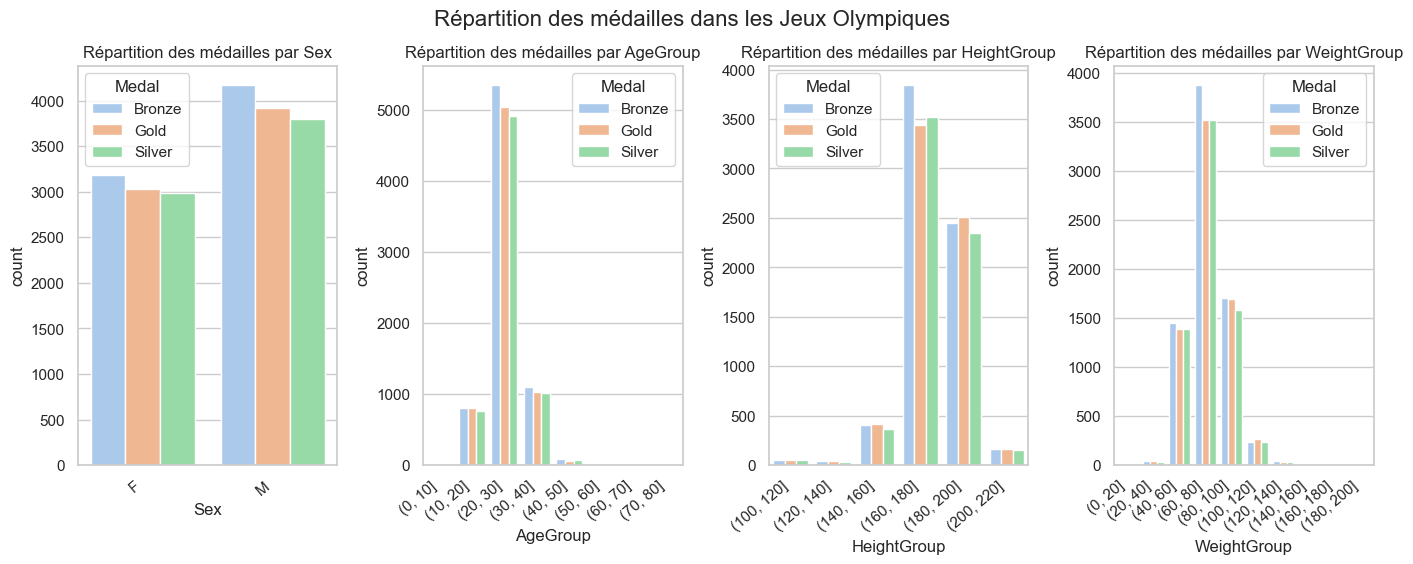

In [197] used 3.9 MiB RAM in 0.88s (system mean cpu 47%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 722.5 MiB


In [197]:
# Paramètres de style de Seaborn
sns.set(style="whitegrid")

# Créer la figure
figure = plt.figure(figsize=(14, 10))
figure.suptitle('Répartition des médailles dans les Jeux Olympiques', fontsize=16)

# Ajuster l'espacement entre les sous-graphiques
plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.5, wspace=0.4)

# Boucle sur les attributs pour créer les sous-graphiques
for i, col in enumerate(attrs):
    plt.subplot(2, 4, i+1)
    plt.xticks(rotation=40, ha='right')  # Rotation des étiquettes sur l'axe des x
    sns.countplot(x=col, hue='Medal', data=df_complete, palette='pastel')  # Utiliser une palette de couleurs pastel
    plt.title('Répartition des médailles par ' + col)  # Titre du sous-graphique

# Améliorer la disposition des sous-graphiques
plt.tight_layout()
plt.show()

#### Analyse visuelle

Nombre d'événements dans chaque sport au fil des années 

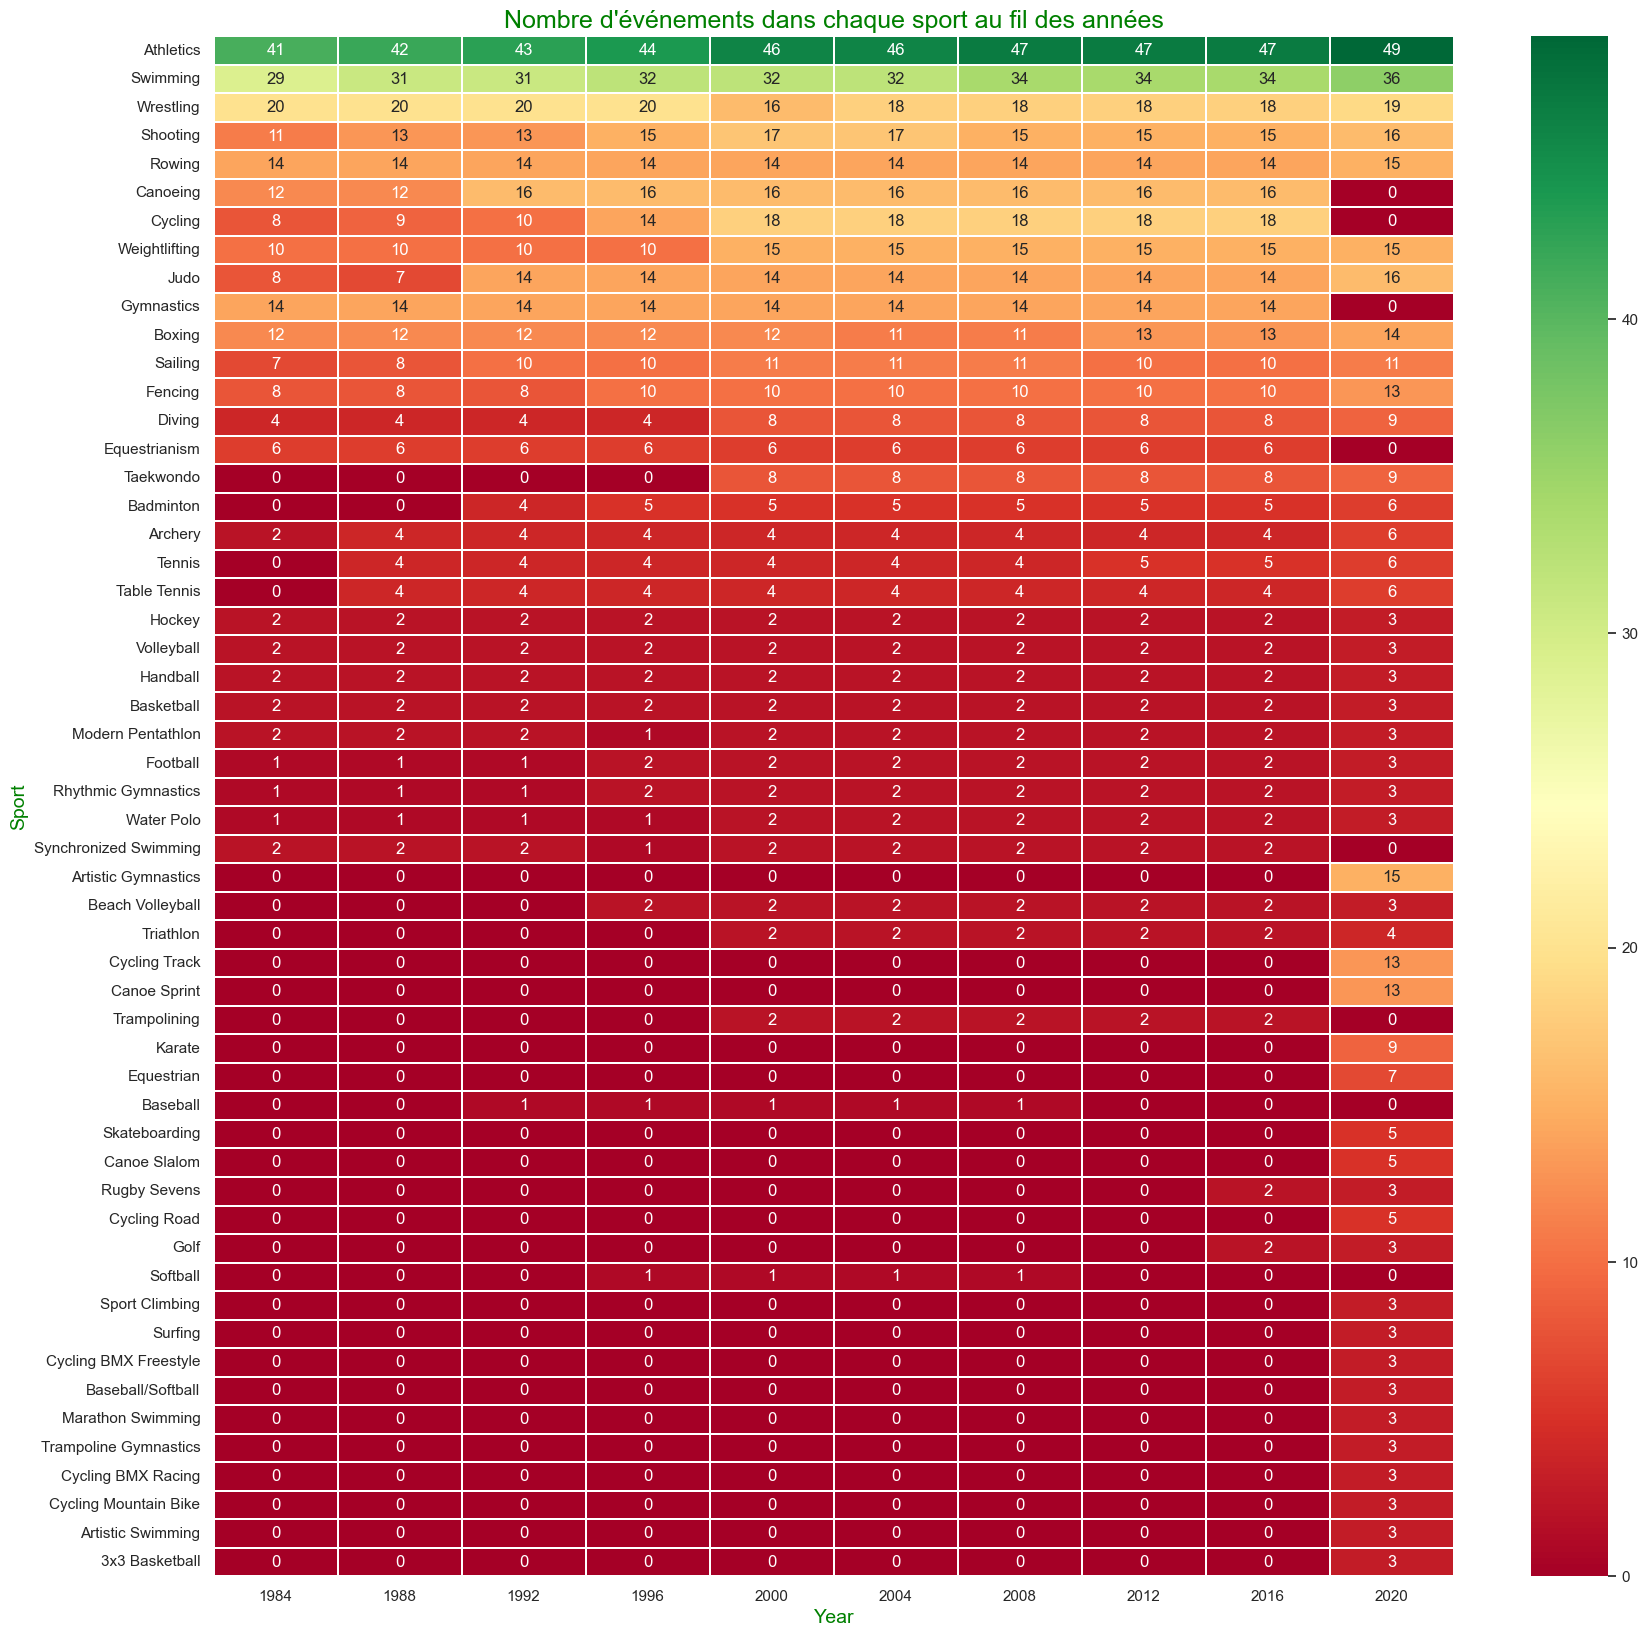

In [198] used 3.0 MiB RAM in 1.10s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 725.5 MiB


In [198]:
sport_year = df_complete.pivot_table(index='Sport', columns='Year', values='Event', aggfunc=lambda x: len(x.unique()))
sport_year.fillna(0, inplace=True)
sport_year = sport_year.reindex(sport_year.sum(axis=1).sort_values(ascending=False).index)

# Affichage de la heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(sport_year, annot=True, linewidths=0.05, cmap="RdYlGn")
plt.xlabel('Year', size=14, color="green")
plt.ylabel('Sport', size=14, color="green")
plt.title('Nombre d\'événements dans chaque sport au fil des années', size=18, color="green")
plt.show()

Nombre total de médailles remportées par pays et type de médaille

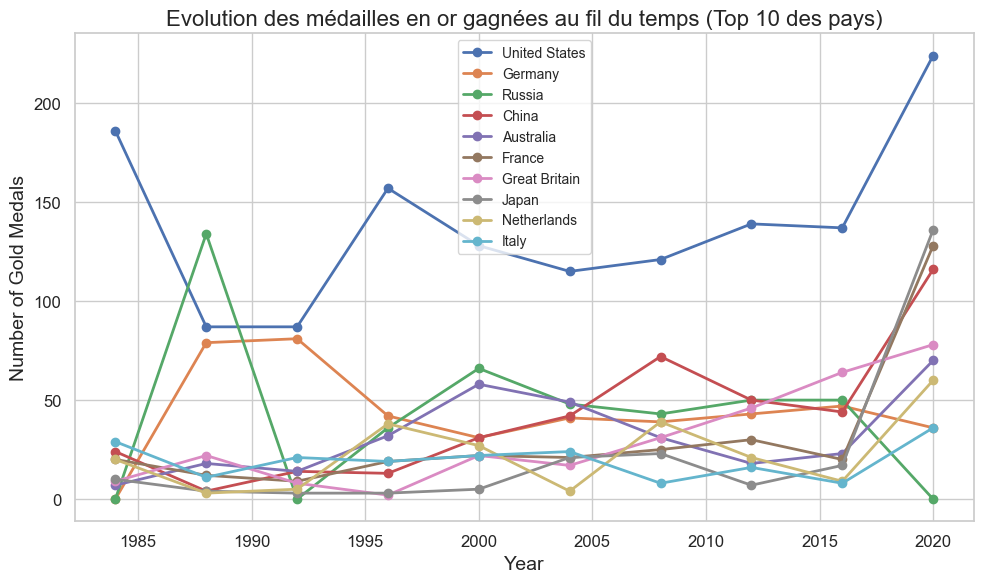

In [199] used -40.1 MiB RAM in 0.40s (system mean cpu 32%, single max cpu 100%), peaked 40.1 MiB above final usage, current RAM usage now 685.4 MiB


In [199]:
# Filter the data to include only gold medal winners
gold_medals = df_complete[df_complete['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_by_year_and_country.index, gold_medals_by_year_and_country[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Evolution des médailles en or gagnées au fil du temps (Top 10 des pays)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y
plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


Nombre total de médailles remportées par pays et type de médaille

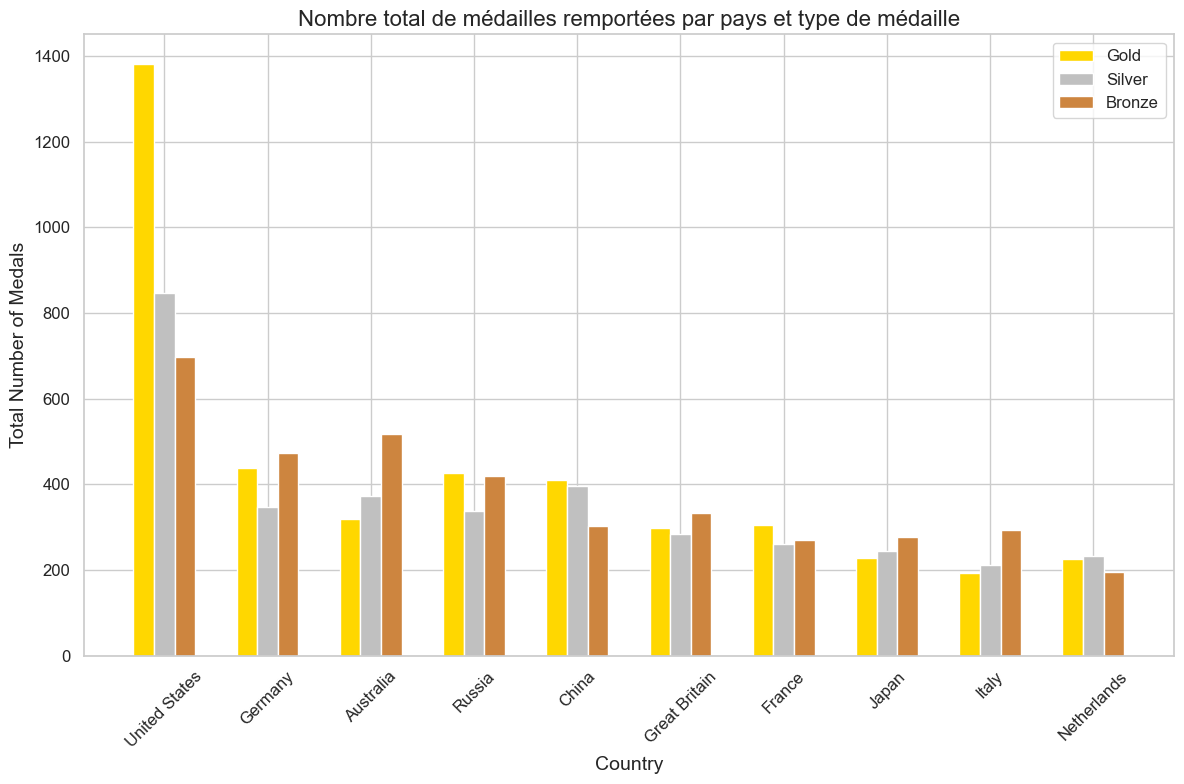

In [200] used -76.5 MiB RAM in 0.38s (system mean cpu 23%, single max cpu 100%), peaked 76.9 MiB above final usage, current RAM usage now 608.9 MiB


In [200]:

# Group the data by country and count the total number of medals won by each country and each type of medal
medals_by_country = df_complete.groupby(['Team', 'Medal']).size().unstack(fill_value=0)

# Select the top 10 countries with the most total medals
top_10_countries = medals_by_country.sum(axis=1).nlargest(10).index

# Select the medal types
medal_types = ['Gold', 'Silver', 'Bronze']

# Set the position of each bar on the x-axis
x = np.arange(len(top_10_countries))

# Set the width of the bars
width = 0.2

# Assign colors to each medal type
colors = {'Gold': 'gold', 'Silver': 'silver', 'Bronze': 'peru'}

# Plotting the grouped bar graph
plt.figure(figsize=(12, 8))  # Taille de la figure

for i, medal in enumerate(medal_types):
    plt.bar(x - width + i * width, medals_by_country.loc[top_10_countries, medal], 
            width=width, label=medal, color=colors[medal])

plt.title('Nombre total de médailles remportées par pays et type de médaille', fontsize=16)  # Titre
plt.xlabel('Country', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Total Number of Medals', fontsize=14)  # Étiquette de l'axe y
plt.xticks(ticks=x, labels=top_10_countries, rotation=45, fontsize=12)  # Étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y
plt.legend(fontsize=12)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()


Ratio de l'évolution des médailles d'or par athlète au fil du temps (Top 10 des pays)
(proportionnelement, quel pays obtient le pus de médailles)

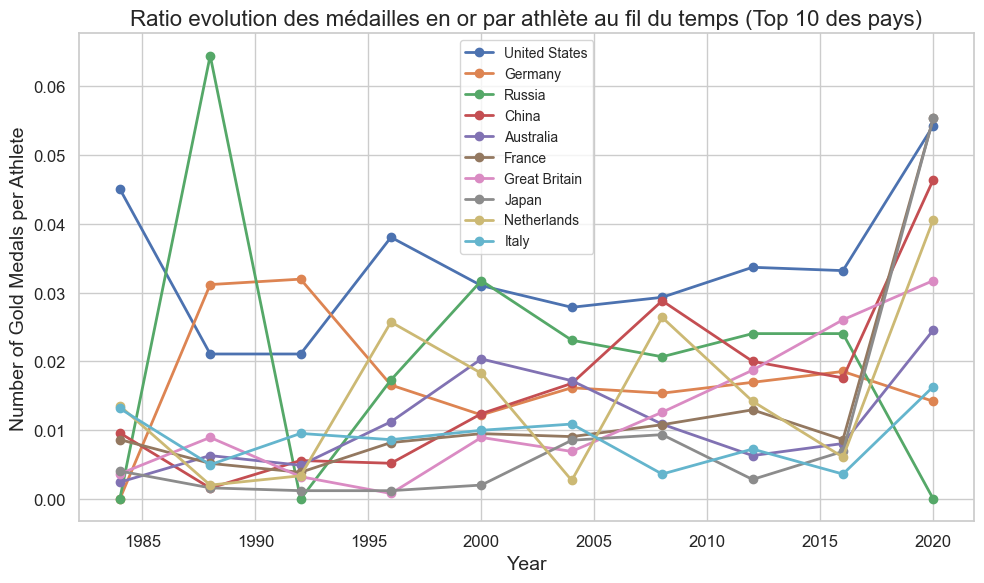

In [201] used -20.2 MiB RAM in 0.47s (system mean cpu 31%, single max cpu 100%), peaked 22.7 MiB above final usage, current RAM usage now 588.7 MiB


In [201]:
# Calculate the total number of athletes per country
total_athletes_per_country = df_complete.groupby('Team')['Name'].nunique()

# Filter the data to include only gold medal winners
gold_medals = df_complete[df_complete['Medal'] == 'Gold']

# Group the data by year and count the number of gold medals won each year for each country
gold_medals_by_year_and_country = gold_medals.groupby(['Year', 'Team'])['Medal'].count().unstack()

# Calculate the number of gold medals per athlete for each country and each year
gold_medals_per_athlete = gold_medals_by_year_and_country.div(total_athletes_per_country, axis=1)

# Select the top 10 countries with the most gold medals overall
top_10_countries = gold_medals.groupby('Team')['Medal'].count().nlargest(10).index

# Plotting the curve for the evolution of gold medals per athlete over time for the top 10 countries
plt.figure(figsize=(10, 6))  # Taille de la figure

for country in top_10_countries:
    plt.plot(gold_medals_per_athlete.index, gold_medals_per_athlete[country], 
             marker='o', markersize=6, linewidth=2, label=country)  # Courbe pour chaque pays avec la légende

plt.title('Ratio evolution des médailles en or par athlète au fil du temps (Top 10 des pays)', fontsize=16)  # Titre
plt.xlabel('Year', fontsize=14)  # Étiquette de l'axe x
plt.ylabel('Number of Gold Medals per Athlete', fontsize=14)  # Étiquette de l'axe y
plt.xticks(fontsize=12)  # Taille de la police des étiquettes de l'axe x
plt.yticks(fontsize=12)  # Taille de la police des étiquettes de l'axe y

plt.grid(True)  # Afficher la grille
plt.legend(fontsize=10)  # Ajouter la légende
plt.tight_layout()  # Ajuster la mise en page
plt.show()

Plus forte évolution des médailles remportées par équipe

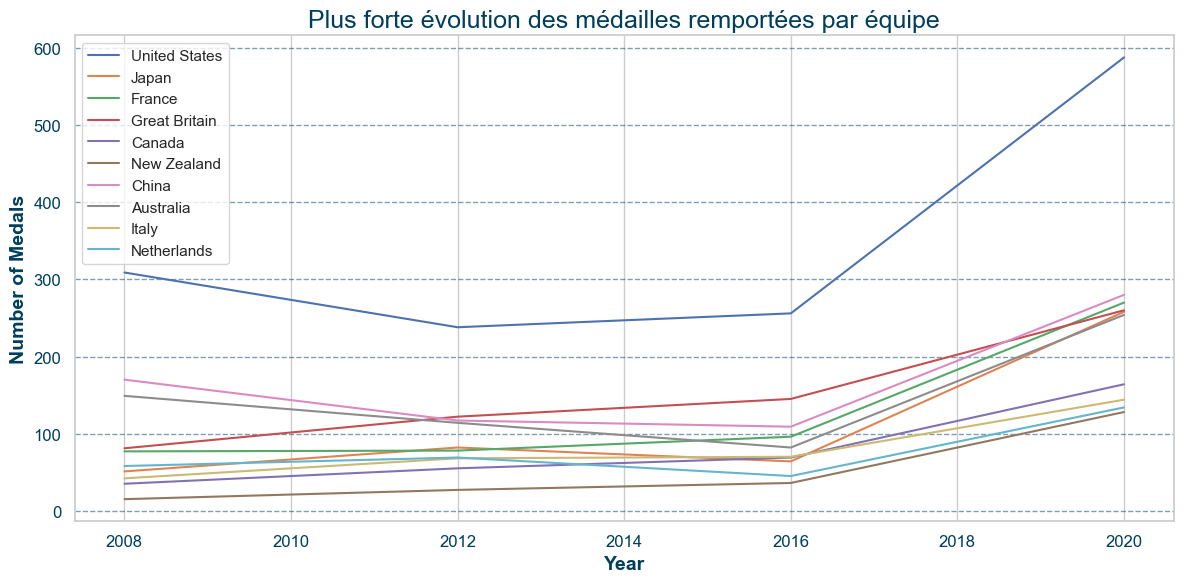

In [202] used -5.0 MiB RAM in 0.40s (system mean cpu 36%, single max cpu 100%), peaked 5.0 MiB above final usage, current RAM usage now 583.7 MiB


In [202]:
# Filter the data to include only Summer Olympic Games between 2010 and 2020
summer_games = df_complete[(df_complete['Season'] == 'Summer') & (df_complete['Year'] >= 2008) & (df_complete['Year'] <= 2020)]

# Group the data by team and year, and calculate the total number of medals won by each team in each year
medals_by_year = summer_games.groupby(['Team', 'Year'])['Medal'].count().unstack()

# Calculate the difference in the number of medals won by each team between the first year and the last year
medal_difference = medals_by_year.iloc[:, -1] - medals_by_year.iloc[:, 0]

# Sort the teams based on the difference in the number of medals won in descending order
sorted_teams = medal_difference.sort_values(ascending=False)

# Select the top 5 teams with the largest increase in medals won
top_5_teams = sorted_teams.index[:10]

# Create a line chart showing the number of medals won by the top 5 teams in each year
plt.figure(figsize=(12, 6))
for team in top_5_teams:
    plt.plot(medals_by_year.loc[team], label=team)
plt.title('Plus forte évolution des médailles remportées par équipe', fontsize=18, color='#003f5c')
plt.xlabel('Year', fontsize=14, fontweight='bold', color='#003f5c')
plt.ylabel('Number of Medals', fontsize=14, fontweight='bold', color='#003f5c')
plt.xticks(fontsize=12, color='#003f5c')
plt.yticks(fontsize=12, color='#003f5c')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#003f5c')
plt.legend()
plt.tight_layout()
plt.show()

In [203]:
# Retrait des variables devenues ici inutiles
df_complete.drop(columns=['AgeGroup', 'WeightGroup', 'HeightGroup'], inplace=True)

In [203] used 0.3 MiB RAM in 0.11s (system mean cpu 19%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 584.0 MiB


## Traitement des valeurs aberrantes

In [204]:
# A faire
# TODO : Guillaume

In [204] used -0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 584.0 MiB


<Axes: >

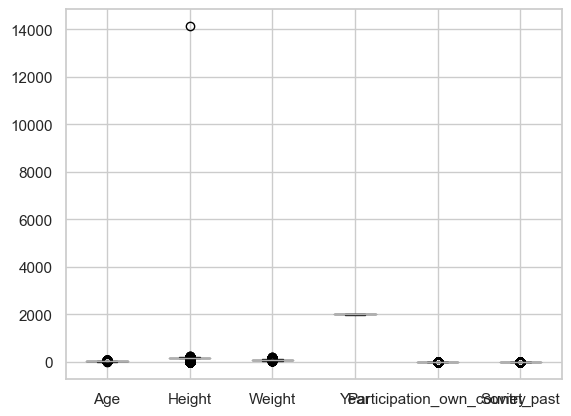

In [205] used 1.2 MiB RAM in 0.71s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 585.2 MiB


In [205]:
df_complete.boxplot()

In [206]:
# On va modifier les plus hauts outliers identifiés pour Age, Height et Weight par la valeur du 99ème quantile

cols = ['Age', 'Height', 'Weight']
low = .05
high = .99 # Retourne les valeurs au 99ème quantile

# Calcul des quantiles
quant_df =  df_complete[cols].quantile([low, high])
print(quant_df)

# Remplacement des outliers par le 99ème quantile
for col in cols:
    high_val = quant_df[col].loc[high]
    df_complete[col] = np.where(df_complete[col] > high_val, high_val, df_complete[col])


       Age  Height  Weight
0.05  18.0   141.5    50.0
0.99  43.0   202.0   115.0
In [206] used 0.1 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 585.4 MiB


In [207]:
higher = quant_df.loc[high,'Age']

def func(x):
    if x >= higher:
        return higher
    else:
        return x

df_complete['Age'] = df_complete['Age'].apply(func)

In [207] used 0.0 MiB RAM in 0.13s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 585.4 MiB


In [208]:
higher = quant_df.loc[high,'Height']

def func(x):
    if x >= higher:
        return higher
    else:
        return x

df_complete['Height'] = df_complete['Height'].apply(func)

In [208] used 0.0 MiB RAM in 0.13s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 585.5 MiB


In [209]:
higher = quant_df.loc[high,'Weight']

def func(x):
    if x >= higher:
        return higher
    else:
        return x

df_complete['Weight'] = df_complete['Weight'].apply(func)

In [209] used -0.1 MiB RAM in 0.14s (system mean cpu 11%, single max cpu 100%), peaked 0.1 MiB above final usage, current RAM usage now 585.4 MiB


In [210]:
# On vérifie que pour les valeurs les plus hautes, on a bien modifié la valeur
df_complete[df_complete['Age'].ge(quant_df.loc[high,'Age'])]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Host_country,Participation_own_country,Soviet_past
181,"William ""Bill"" Abbott Jr.",M,43.0,172.00,80.00000,Canada,CAN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Mixed Three Person Keelboat,NaN,Canada,Australia,0,0
1044,"Phillip Maxwell ""Phil"" Adams",M,43.0,163.00,93.00000,Australia,AUS,1988 Summer,1988,Summer,Seoul,Shooting,"Shooting Men's Air Pistol, 10 metres",NaN,Australia,Canada,0,0
1045,"Phillip Maxwell ""Phil"" Adams",M,43.0,163.00,93.00000,Australia,AUS,1988 Summer,1988,Summer,Seoul,Shooting,"Shooting Men's Free Pistol, 50 metres",NaN,Australia,Canada,0,0
1046,"Phillip Maxwell ""Phil"" Adams",M,43.0,163.00,93.00000,Australia,AUS,1992 Summer,1992,Summer,Barcelona,Shooting,"Shooting Men's Air Pistol, 10 metres",NaN,Australia,France,0,0
1047,"Phillip Maxwell ""Phil"" Adams",M,43.0,163.00,93.00000,Australia,AUS,1992 Summer,1992,Summer,Barcelona,Shooting,"Shooting Men's Free Pistol, 50 metres",NaN,Australia,France,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244675,VORSTER Michelle,F,43.0,167.00,55.40625,Namibia,NAM,Tokyo 2020,2020,Summer,Tokyo,Cycling Mountain Bike,NaN,NaN,Namibia,Japan,0,0
244783,WERTH Isabell,F,43.0,164.25,60.81250,Germany,GER,Tokyo 2020,2020,Summer,Tokyo,Equestrian,Dressage Team,Gold,Germany,Japan,0,0
244784,WERTH Isabell,F,43.0,164.25,60.81250,Germany,GER,Tokyo 2020,2020,Summer,Tokyo,Equestrian,Dressage Individual,Silver,Germany,Japan,0,0
244965,YARUR Virginia,F,43.0,166.75,61.18750,Chile,CHI,Tokyo 2020,2020,Summer,Tokyo,Equestrian,NaN,NaN,Chile,Japan,0,0


In [210] used 0.1 MiB RAM in 0.14s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 585.5 MiB


In [211]:
df_complete[df_complete['Height'].ge(quant_df.loc[high, 'Height'])]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Host_country,Participation_own_country,Soviet_past
194,Hossam Abdalla,M,28.0,202.0,97.0000,Egypt,EGY,2016 Summer,2016,Summer,Rio de Janeiro,Volleyball,Volleyball Men's Volleyball,NaN,Egypt,Brazil,0,0
327,Mamdouh Abdelrehim,M,26.0,202.0,90.0000,Egypt,EGY,2016 Summer,2016,Summer,Rio de Janeiro,Volleyball,Volleyball Men's Volleyball,NaN,Egypt,Brazil,0,0
469,Julius Shareef Abdur-Rahim,M,23.0,202.0,104.0000,United States,USA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,Gold,United States,Australia,0,0
594,Abdelhalim Muhammad Abou,M,27.0,202.0,88.0000,Egypt,EGY,2016 Summer,2016,Summer,Rio de Janeiro,Volleyball,Volleyball Men's Volleyball,NaN,Egypt,Brazil,0,0
607,Essameldin Abou El-Nein,M,29.0,202.0,102.0000,Egypt,EGY,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Men's Basketball,NaN,Egypt,Yugoslavia,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233804,Zheng Haixia,F,25.0,202.0,115.0000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Women's Basketball,Silver,China,France,0,0
233805,Zheng Haixia,F,29.0,202.0,115.0000,China,CHN,1996 Summer,1996,Summer,Atlanta,Basketball,Basketball Women's Basketball,NaN,China,United States,0,0
241345,GRINER Brittney,F,31.0,202.0,82.3750,United States,USA,Tokyo 2020,2020,Summer,Tokyo,Basketball,Women,Gold,United States,Japan,0,0
241434,HAN Xu,F,22.0,202.0,73.1875,China,CHN,Tokyo 2020,2020,Summer,Tokyo,Basketball,NaN,NaN,China,Japan,0,0


In [211] used -0.1 MiB RAM in 0.12s (system mean cpu 32%, single max cpu 100%), peaked 0.1 MiB above final usage, current RAM usage now 585.4 MiB


In [212]:
df_complete[df_complete['Weight'].ge(quant_df.loc[high,'Weight'])]

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country,Host_country,Participation_own_country,Soviet_past
27,Timo Antero Aaltonen,M,31.0,189.0,115.0,Finland,FIN,2000 Summer,2000,Summer,Sydney,Athletics,Athletics Men's Shot Put,NaN,Finland,Australia,0,0
273,Yasser Abdel Rahman Sakr,M,30.0,180.0,115.0,Egypt,EGY,2008 Summer,2008,Summer,Beijing,Wrestling,"Wrestling Men's Super-Heavyweight, Greco-Roman",NaN,Egypt,China,0,0
454,Muminzhon Abdullayev,M,22.0,190.0,115.0,Uzbekistan,UZB,2012 Summer,2012,Summer,London,Wrestling,"Wrestling Men's Super-Heavyweight, Greco-Roman",NaN,Uzbekistan,United Kingdom,0,1
455,Muminzhon Abdullayev,M,26.0,190.0,115.0,Uzbekistan,UZB,2016 Summer,2016,Summer,Rio de Janeiro,Wrestling,"Wrestling Men's Super-Heavyweight, Greco-Roman",NaN,Uzbekistan,Brazil,0,1
474,Mukhamadmurod Abdurakhmonov,M,29.0,192.0,115.0,Tajikistan,TJK,2016 Summer,2016,Summer,Rio de Janeiro,Judo,Judo Men's Heavyweight,NaN,Tajikistan,Brazil,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233802,Zheng Haixia,F,17.0,202.0,115.0,China,CHN,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Women's Basketball,Bronze,China,Yugoslavia,0,0
233803,Zheng Haixia,F,21.0,202.0,115.0,China,CHN,1988 Summer,1988,Summer,Seoul,Basketball,Basketball Women's Basketball,NaN,China,Canada,0,0
233804,Zheng Haixia,F,25.0,202.0,115.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Women's Basketball,Silver,China,France,0,0
233805,Zheng Haixia,F,29.0,202.0,115.0,China,CHN,1996 Summer,1996,Summer,Atlanta,Basketball,Basketball Women's Basketball,NaN,China,United States,0,0


In [212] used -35.0 MiB RAM in 0.12s (system mean cpu 22%, single max cpu 100%), peaked 29.5 MiB above final usage, current RAM usage now 550.4 MiB


In [213]:
## Création d'un nouveau dataframe aggrégeant toutes les données
df_without_medals_duplicates = df_complete.drop_duplicates(subset=['Event', 'Country', 'Year', 'Medal'])
participation_own_country_soviet = df_without_medals_duplicates[['Year','Country', 'Participation_own_country', 'Soviet_past']].drop_duplicates()

df_without_medals_duplicates['Medal'] = df_without_medals_duplicates['Medal'].replace(np.nan, 0)
df_without_medals_duplicates['Medal'] = df_without_medals_duplicates['Medal'].apply(lambda x: 0 if x==0 else 1)

medals_per_year = df_without_medals_duplicates.groupby(['Country', 'Year']).agg({'Medal': 'sum'}).reset_index()
df_agg_country_year_medals = medals_per_year.merge(participation_own_country_soviet, how='inner', on=['Country', 'Year'])

# Optimisation
df_agg_country_year_medals = define_and_use_optimal_type(df_agg_country_year_medals)

# Vérif
df_agg_country_year_medals[df_agg_country_year_medals['Country'] == "France"]

/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_10787/2782498913.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_medals_duplicates['Medal'] = df_without_medals_duplicates['Medal'].replace(np.nan, 0)
/var/folders/38/1vcxjcxx0z75mdh8whh4pw6r0000gn/T/ipykernel_10787/2782498913.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_medals_duplicates['Medal'] = df_without_medals_duplicates['Medal'].apply(lambda x: 0 if x==0 else 1)


,Country,Year,Medal,Participation_own_country,Soviet_past
600,France,1984,28,0,0
601,France,1988,16,0,0
602,France,1992,29,1,0
603,France,1996,37,0,0
604,France,2000,38,0,0
605,France,2004,33,0,0
606,France,2008,41,0,0
607,France,2012,35,0,0
608,France,2016,42,0,0
609,France,2020,32,0,0


In [213] used 1.3 MiB RAM in 0.13s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 551.7 MiB


In [214]:
df_agg_country_year_medals = df_agg_country_year_medals[df_agg_country_year_medals['Year'] > 1980]

In [214] used -0.0 MiB RAM in 0.11s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 551.7 MiB


In [215]:
df_agg_country_year_medals

,Country,Year,Medal,Participation_own_country,Soviet_past
0,Afghanistan,1988,0,0,0
1,Afghanistan,1996,0,0,0
2,Afghanistan,2004,0,0,0
3,Afghanistan,2008,1,0,0
4,Afghanistan,2012,1,0,0
...,...,...,...,...,...
1874,Zimbabwe,2004,3,0,0
1875,Zimbabwe,2008,4,0,0
1876,Zimbabwe,2012,0,0,0
1877,Zimbabwe,2016,0,0,0


In [215] used 0.0 MiB RAM in 0.11s (system mean cpu 27%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 551.8 MiB


In [216]:
# On ajoute le nombre d'athlètes par année
df_complete.drop_duplicates(subset=['Name', 'NOC', 'Year'], inplace=True)
athlete_amount = (df_complete.groupby(['Country', 'Year']).size().to_frame())
athlete_amount.reset_index(inplace=True)
athlete_amount.rename(columns={0: 'AthletesNumber'}, inplace=True)

df_agg_country_year_medals = df_agg_country_year_medals.merge(athlete_amount, how='inner', on=['Country', 'Year'])

In [216] used -14.0 MiB RAM in 0.14s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 537.8 MiB


In [217]:
# On aggrège le GDP obtenu précédemment
testest = df_agg_country_year_medals.merge(pop_gdp_df, on=['Country', 'Year'], how='inner')
# Il y a quelques champs vides pour le GDP, on retire les éléments qui n'existent pas 
testest.dropna(inplace=True)

testest.to_csv('data/df_agg_country_year_medals_gdp.csv', index=False)

# on normalise le gdp parce que c'est de la merde

#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

#Use .loc to explicitly set values on the original DataFrame
#testest.loc[:, ["GDP_per_capita"]] = scaler.fit_transform(testest[["GDP_per_capita"]])
#testest.loc[:, ["Population"]] = scaler.fit_transform(testest[["Population"]])


In [217] used 1.0 MiB RAM in 0.12s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 538.8 MiB


In [218]:
# Récupération de la quantité d'athlètes de chaque sexe par pays

# Create dummy variables for gender
gender_dummies = pd.get_dummies(df_complete['Sex'], prefix='Gender')

# Merge dummy variables into df_complete
df_complete = pd.concat([df_complete, gender_dummies], axis=1)

df_complete['Gender_F'].replace([False,True],[0, 1],inplace=True)
df_complete['Gender_M'].replace([False,True],[0, 1],inplace=True)

sexM_per_year = df_complete.groupby(['Country', 'Year']).agg({'Gender_M': 'sum'}).reset_index()
sexF_per_year = df_complete.groupby(['Country', 'Year']).agg({'Gender_F': 'sum'}).reset_index()

In [218] used -4.3 MiB RAM in 0.13s (system mean cpu 21%, single max cpu 100%), peaked 4.3 MiB above final usage, current RAM usage now 534.5 MiB


In [219]:
# Nous avons un problème de qualité des données au niveau des femmes pour une raison inconnue (qui survient pendant le groupby). Ainsi pour obtenir le nombre exact de femmes à chaque fois, nous allons soustraire la quantité d'hommes à la quantité d'athlètes au total. 

df_gdp_soviet_athlete_sex = testest.merge(sexM_per_year, on=['Country', 'Year'], how='inner')
df_gdp_soviet_athlete_sex['Gender_F'] = df_gdp_soviet_athlete_sex['AthletesNumber'] -df_gdp_soviet_athlete_sex['Gender_M']  

# On créée des % et on drop les autres colonnes
df_gdp_soviet_athlete_sex['Gender_F_Per'] = df_gdp_soviet_athlete_sex['Gender_F'] / df_gdp_soviet_athlete_sex['AthletesNumber'] 
df_gdp_soviet_athlete_sex['Gender_M_Per'] = df_gdp_soviet_athlete_sex['Gender_M'] / df_gdp_soviet_athlete_sex['AthletesNumber']

df_gdp_soviet_athlete_sex.drop(columns=['Gender_F', 'Gender_M'], inplace=True)

In [219] used 0.2 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 534.6 MiB


In [256]:
df_gdp_soviet_athlete_sex.Year.min()

1984

In [256] used -1.9 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 259.5 MiB


## Test des modèles
Ici, nous allons essayer plusieurs modèles de régression et nous allons comparer leur performance (sur la valeur Mean Square Error). Pour les tests, nous allons nous appuyer sur un échantillon de l'ensemble du dataframe, soit des années 1988 à 2020 ; et nous allons aussi essayer de prédire les valeurs de Tokyo dans un second temps en les excluant du jeu d'entraînement. 

### Séparation du train et du test

In [257]:
# On fait un train/test plus classique, avec toutes les données
X_train, X_test, y_train, y_test = train_test_split(df_gdp_soviet_athlete_sex[['Participation_own_country', 'Soviet_past', 'AthletesNumber', 'GDP_per_capita', 'Population', 'Urban Population(%)', 'Gender_F_Per', 'Gender_M_Per']], df_gdp_soviet_athlete_sex['Medal'], test_size=0.33, random_state=42)

In [257] used -40.9 MiB RAM in 0.11s (system mean cpu 20%, single max cpu 41%), peaked 0.0 MiB above final usage, current RAM usage now 218.6 MiB


In [249]:
# On garde un dataset de Tokyo pour tester à part
df_train = df_gdp_soviet_athlete_sex[df_gdp_soviet_athlete_sex['Year'] != 2020]
X_df_train = df_train[['Participation_own_country', 'Soviet_past', 'AthletesNumber',
       'Population', 'GDP_per_capita', 'Urban Population(%)', 'Gender_F_Per',
       'Gender_M_Per']]
y_df_train = df_train['Medal']


df_test = df_gdp_soviet_athlete_sex[df_gdp_soviet_athlete_sex['Year'] == 2020]
X_df_test = df_test[['Participation_own_country', 'Soviet_past', 'AthletesNumber',
       'Population', 'GDP_per_capita', 'Urban Population(%)', 'Gender_F_Per',
       'Gender_M_Per']]
y_df_test = df_test['Medal']

In [249] used -0.2 MiB RAM in 0.11s (system mean cpu 37%, single max cpu 53%), peaked 0.0 MiB above final usage, current RAM usage now 265.1 MiB


### Recherche des meilleurs paramètres des modèles
Nous allons ici essayer plusieurs modèles, certains trouvés en cours et d'autres sur le web
- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor
- XGBoost

Nous allons essayer dans un premier temps de trouver, pour chacun, les meilleurs hyperparamètres possibles, puis nous effectuerons notre choix sur la base de la MSE (Mean Square Error)

Essai de LinearRegression

In [258]:
# Define the hyperparameters to search over
param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1, 1, 2, 4],  # Adjust values as needed
    # Add any other hyperparameters you want to tune
}

# Create a linear regression model
model = LinearRegression()

# Create a grid search object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Fit the model with the best parameters
best_model = LinearRegression(**best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Best Parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Mean Squared Error: 31.98311814519839
R-squared: 0.8261878712335893
In [258] used 3.8 MiB RAM in 0.88s (system mean cpu 72%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 222.4 MiB


Essai du RandomForestRegressor

In [259]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=42)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_rf_regressor = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_rf_regressor.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error: 15.000999071672286
R-squared: 0.9184771300148622
In [259] used -44.3 MiB RAM in 92.78s (system mean cpu 26%, single max cpu 100%), peaked 52.5 MiB above final usage, current RAM usage now 178.1 MiB


Essai du GradientBoostingRegressor

In [260]:
# Define the parameter grid
param_grid = {
    'n_estimators': [150],
    'learning_rate': [0.05],
    'max_depth': [3]
}

# Create a Gradient Boosting Regressor model
gb_regressor = GradientBoostingRegressor(random_state=42)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_gb_regressor = grid_search.best_estimator_

# Make predictions on the test data using th    e best model
y_pred = best_gb_regressor.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}
Mean Squared Error: 24.64790118302147
R-squared: 0.8660510787348523
In [260] used 1.3 MiB RAM in 1.97s (system mean cpu 72%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 179.3 MiB


Test du XGBoost

In [262]:
# Create the XGBRegressor model
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror')

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score (Negative Mean Squared Error):", best_score)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s
[CV] END ...learning_rate=0.1, max_depth=5, n_es

En sachant que plus la Mean Square Error tend vers 0, meilleur le modèle est. 
Voici les résultats des modèles : 
- LinearRegression : MSE=32
- RandomForestRegressor : MSE=15
- GradientBoostingRegressor : MSE=24
- XGBoost : MSE=-18

Deux modèles sortent du lot : RandomForestRegressor et XGBoost. Nous allons ici utiliser le RandomForestRegressor avec les meilleurs paramètres trouvés par GridSearch, à savoir : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Il serait intéressant de connaitre l'importance des features liés à ce modèle.


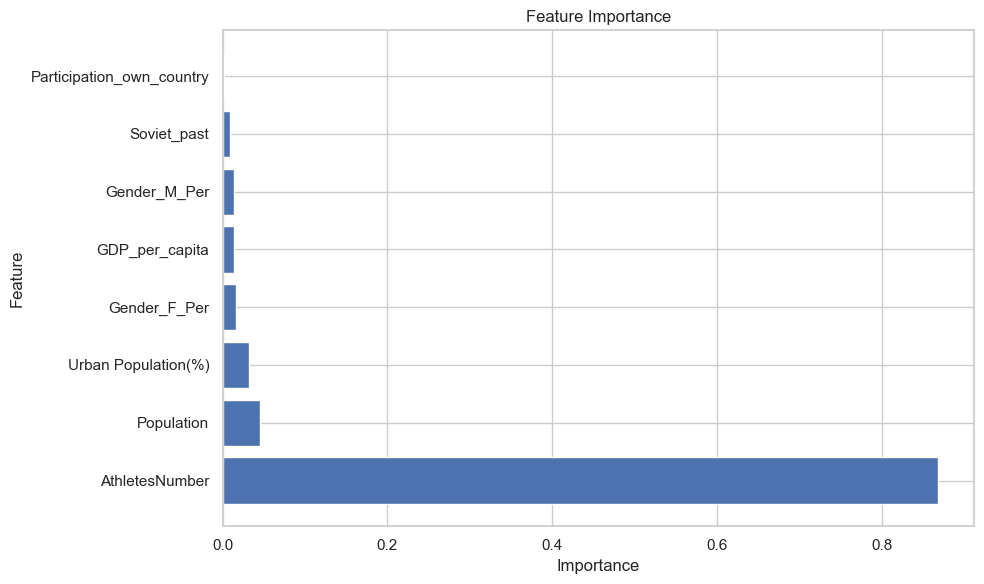

In [270] used 9.0 MiB RAM in 0.29s (system mean cpu 53%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 150.1 MiB


In [270]:
feature_importances = best_rf_regressor.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

On observe ici que la feature ayant le plus d'importance est celle reprenant le nombre d'athlètes, et de loin. Cela remet en perspective l'effort de récupération des autres données ...

## Application du modèle
Nous avons donc choisi d'utiliser le modèle RandomForestRegressor avec les paramètres suivants : 
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

# FIN TEST

In [ ]:
# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared:", r2)

## Encodage des données

In [ ]:
# Make predictions on the df_test data
y_pred_test = model.predict(df_test[['Participation_own_country', 'Soviet_past', 'AthletesNumber', 'GDP_per_capita', 'Population', 'Urban Population(%)', 'Gender_F_Per', 'Gender_M_Per']])

# Append the predicted results to df_test
df_test['Predicted'] = y_pred_test


In [ ]:
df_test.sort_values(by=['Predicted']).tail(10)

# A MODIFIER

In [ ]:
# Corrélogramme
correlation_matrix = df_complete.corr()
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', linewidths=0.5)

On n'observe pas de forte corrélation entre les différents attributs (NOE à compléter)

In [ ]:
# Encodage de l'âge
df_complete['Age'] = pd.cut(df_complete.Age, range(0, 80, 5), right=False)

# Encodage du poids
df_complete['Weight'] = pd.cut(df_complete.Weight, range(0, 230, 10), right=False)

# Encodage de la taille
df_complete['Height'] = pd.cut(df_complete.Height, range(0, 250, 10), right=False)

In [ ]:
# PIB Groups
# Calculer les quantiles
quantiles = [0.20, 0.40, 0.60, 0.80]

# Créer les intervalles pour les groupes en utilisant les quantiles
bins = df_complete['PIB'].quantile(quantiles)

# Ajouter les bornes extrêmes
bins = [float('-inf')] + list(bins) + [float('inf')]

# Assigner les groupes en utilisant pd.cut() avec les intervalles définis
df_complete['PIB_groups'] = pd.cut(df_complete['PIB'], bins=bins, labels=[1, 2, 3, 4, 5], right=False)

# Retrait des variables inutiles
df_complete.drop(columns=['PIB'], inplace=True)
df_complete

In [ ]:
categorical_vars = df_complete.select_dtypes(include=['object', 'category'])

p_values = {}
for var1, var2 in combinations(categorical_vars.columns, 2):
    contingency_table = pd.crosstab(categorical_vars[var1], categorical_vars[var2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_values[(var1, var2)] = p


dependent_vars = {var_pair: p_value for var_pair, p_value in p_values.items() if p_value < 0.05}
dependent_vars

### Nettoyage des colonnes inutiles pour l'analyse

In [ ]:
# Drop les colonnes qui ne servent à R
# df_complete.drop(columns=['Team', 'Name', 'Games', 'City', 'Event', 'Sport', 'Host_country', 'Country'], inplace=True)

## Traitement des valeurs manquantes

## Tests de corrélations/lois stats (Shapiro-Wilk, Spearman, Pearson)

In [271]:
# TODO: Noé

In [271] used -26.1 MiB RAM in 0.11s (system mean cpu 28%, single max cpu 46%), peaked 0.0 MiB above final usage, current RAM usage now 124.0 MiB
